# Reproduce calstis output manually

Attempt to produce the same output as calstis, but using the individual modules.

Ultimately, the way I figured out how to do this was I ran the calstis_test notebook to produce full *_trl.log files for calstis. Then, I compared the order of modules in the logfile with their inputs, outputs, and switches (e.g., CALSTIS-7) to [Table 3.1](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration/3-2-structure-of-calstis#id-3.2Structureofcalstis-table3.1). I ran this incrementally until my manual log file matched the one from calstis.

I get perfect agreement with the calstis pipeline.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import glob
from astropy.io import fits
import stistools
import os
from astroquery.mast import Observations
from pathlib import Path
from stistools import basic2d

import sys
sys.path.insert(0,'/Users/runnojc1/Dropbox/Research/teaching/S2021/ASTR8060/work/reductions/example/notebooks/')
from convenience_functions import show_image
from astropy.nddata import CCDData

In [3]:
# set plotting defaults for latex axis labels
plt.rc('text',usetex=True)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Times",
})

In [4]:
%%html
<! left aligns table in cell below>
<style>
    table {
        display: inline-block
    }
</style>

## How does calstis actually work?

[Table 3.5](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration/3-5-recalibration-of-stis-data#id-3.5RecalibrationofSTISData-3.5.23.5.2RerunningSubsetsoftheCalibrationPipeline) lists the individual steps:

| Task | Description | 
| --- | :--- |
| inttag | Integrate TIME-TAG event list to form one or more raw images. |
| basic2d |  Perform basic 2-D calibration on a raw image. |
| ocrreject | Combine images, rejecting cosmic rays. |
| wavecal | Process wavecal images. |
| x1d | Extract 1-D spectrum. |
| x2d | Rectify 2-D spectral images. |

[Table 3.1]() is even more informative, because it lists all of the steps that calstis takes:

| stistools task | Description of Processing Modules | Module |
| --- | :--- | :--- |
| | **Full Pipeline** |
| calstis |“Wrapper” program calls each of the calstis tasks as needed, according to the switches set in the primary header of the input file. The calstis constituent tasks can instead be executed independently when recalibrating. | calstis0 |
| | **Initial 2-D Image Reduction** |
| basic2d | Fundamental steps of 2-D image reduction. This module is called to initialize the data quality array from the bad pixel table, to trim the overscan regions and subtract the bias level, and to subtract the bias image (before cosmic ray rejection for CCD data), then to subtract the dark image and perform flat fielding (after cosmic ray rejection). It assigns values to the error arrays and computes some simple statistics. | calstis1 |
| ocrreject |Detect and remove cosmic rays in CCD data. This module identifies cosmic rays (by optionally flagging them in the input file) for multiple images taken at the same pointing. The input images are then co-added, resulting in an image with cosmic rays removed. | calstis2 |
| | **Contemporaneous Wavecal Processing** |
| wavecal |Determine MSM offset from wavecal. This step is used in conjunction with calstis7, calstis11, and calstis12. Its purpose is to find the offset of the spectrum from the expected location, owing to nonrepeatability of the mode select mechanism. The shift is written into the SCI extension header of the input wavecal image. | calstis4 |
|| Subtract science image from wavecal. For CCD wavecal observations taken with the HITM system prior to 1998-Nov-9, the detector is exposed to both the wavecal and the science target (after this date, the external shutter would be closed). This task reads both the wavecal and science files and subtracts the science data from the wavecal. Following this step, calstis4 can be used to determine the spectral shift. | calstis11 |
|| Write spectral shift value to science header. A series of science images (i.e., CR-SPLIT or REPEATOBS) and wavecals may have been taken, with the wavecals interspersed in time among the science images. For each image in the science file, this task linearly interpolates the wavecals to the time of the science image, and then writes the keyword values SHIFTA1, SHIFTA2 for the spectral and spatial shifts, respectively, to the science header. | calstis12 |
| | **Spectroscopic Calibration, Extraction, and Rectification** |
| x1d | 1-D spectral extraction. This task is most appropriate for observations of a point source. A spectrum is extracted along a narrow band, summed over the cross-dispersion direction and background values subtracted to produce a 1-D array of fluxes for each spectral order. An array of wavelengths is generated, with each output spectrum written to a separate row of a FITS binary table, together with the arrays of the gross, net, and background count rates. One output table is generated for each image in a series of REPEATOBS data. For echelle observations, x1d and the echelle scattered light correction routine are called iteratively, to calculate the echelle background. | calstis6 |
| x2d | 2-D rectification. This task performs geometric correction for direct imaging or long slit spectroscopic data. For the latter, it produces a spectral image that is linear in both wavelength and spatial directions. | calstis7 |

## Data wrangling

In [5]:
# update this depending on your machine
raw_dir     = '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/raw/'
man_dir     = '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/'
pipe_dir    = '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/pipe/'

# make the directories if they doesn't exist
Path(man_dir).mkdir(exist_ok=True)

# go to your pipeline reduction directory
os.chdir(man_dir)
print("Current directory is: "+os.getcwd())

Current directory is: /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual


In [6]:
# set the directories with reference files
%env lref /Users/runnojc1/crds_cache/references/hst/stis/
%env oref /Users/runnojc1/crds_cache/references/hst/stis/

env: lref=/Users/runnojc1/crds_cache/references/hst/stis/
env: oref=/Users/runnojc1/crds_cache/references/hst/stis/


In [7]:
# copy the pipeline _raw files to the reduced directory
# the pipeline also needs the _wav and _epc files
os.system('cp '+raw_dir+'*_raw.fits '+man_dir)
os.system('cp '+raw_dir+'*_epc.fits '+man_dir)
os.system('cp '+raw_dir+'*_wav.fits '+man_dir)

# grab the raw files
raw_files = np.sort(glob.glob('*0_raw.fits'))
raw_files

array(['obji14010_raw.fits', 'obji14020_raw.fits', 'obji14030_raw.fits',
       'obji15010_raw.fits', 'obji15020_raw.fits', 'obji15030_raw.fits',
       'obji16010_raw.fits', 'obji16020_raw.fits', 'obji16030_raw.fits',
       'obji17010_raw.fits', 'obji17020_raw.fits', 'obji17030_raw.fits',
       'obji18010_raw.fits', 'obji18020_raw.fits', 'obji18030_raw.fits',
       'obji19010_raw.fits', 'obji19020_raw.fits', 'obji19030_raw.fits',
       'obji20010_raw.fits', 'obji20020_raw.fits', 'obji20030_raw.fits',
       'obji21010_raw.fits', 'obji21020_raw.fits', 'obji21030_raw.fits'],
      dtype='<U18')

In [8]:
# update the pmap file in the file headers
%env CRDS_PATH /Users/runnojc1/crds_cache
%env CRDS_SERVER_URL https://hst-crds.stsci.edu
%env oref /Users/runnojc1/crds_cache/references/hst/oref/

os.system('crds bestrefs --update-bestrefs --sync-references=1 --files *_raw.fits')
os.system('crds bestrefs --update-bestrefs --sync-references=1 --files *_wav.fits')

env: CRDS_PATH=/Users/runnojc1/crds_cache
env: CRDS_SERVER_URL=https://hst-crds.stsci.edu
env: oref=/Users/runnojc1/crds_cache/references/hst/oref/


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing obji14010_raw.fits
CRDS - INFO -  ===> Processing obji14020_raw.fits
CRDS - INFO -  ===> Processing obji14030_raw.fits
CRDS - INFO -  ===> Processing obji15010_raw.fits
CRDS - INFO -  ===> Processing obji15020_raw.fits
CRDS - INFO -  ===> Processing obji15030_raw.fits
CRDS - INFO -  ===> Processing obji16010_raw.fits
CRDS - INFO -  ===> Processing obji16020_raw.fits
CRDS - INFO -  ===> Processing obji16030_raw.fits
CRDS - INFO -  ===> Processing obji17010_raw.fits
CRDS - INFO -  ===> Processing obji17020_raw.fits
CRDS - INFO -  ===> Processing obji17030_raw.fits
CRDS - INFO -  ===> Processing obji18010_raw.fits
CRDS - INFO -  ===> Processing obji18020_raw.fits
CRDS - INFO -  ===> Processing obji18030_raw.fits
CRDS - INFO -  ===> Processing obji19010_raw.fits
CRDS - INFO -  ===> Processing obji19020_raw.fits
CRDS - INFO -  ===> Processing obji19030_raw.fits
CRDS - INFO -  ===> Processing 

0

## 2D Image Processing

From [Figure 3.1](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration/3-2-structure-of-calstis#id-3.2Structureofcalstis-table3.1):

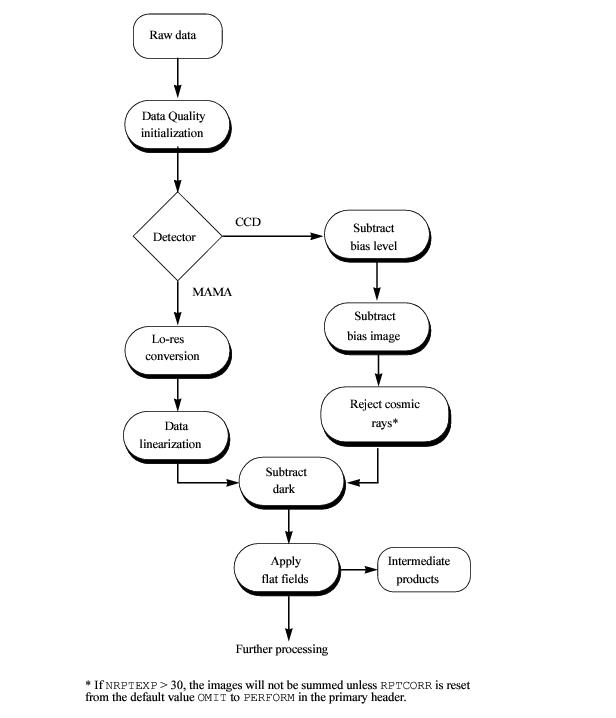


So execute the following steps:
1. Subtract bias level and image.
2. CR rejection.
3. Subtract dark.
4. Apply flat fields.

The output of this process is the _crj.fits image. It also saves a _flt.fits file, which has everything but the CR rejection. This should not be used for later CR rejection (see [Sec 3.5.4](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration/3-5-recalibration-of-stis-data#id-3.5RecalibrationofSTISData-3.5.23.5.2RerunningSubsetsoftheCalibrationPipeline)), because that module uses a Poisson distribution that would be wrong.

In [9]:
# do the bias correction
# loop over the raw files
# this will handle multiple CRSPLIT extensions per file
for raw_file in raw_files:
    print('Reducing '+raw_file+'.')
    # get the root filename
    file = raw_file.replace('_raw.fits','',1)
    
    # preference is given to tasks requested in header keywords over in basic2d below
    # set these so that we only do the bias correction tasks
    # turn off all the corrections except for the three for bias
    #set_basic2d_keys(all_corrs,man_dir+raw_file)                              
            
    # run the bias level and frame subtraction
    print('    Starting bias subtraction...')
    stistools.basic2d.basic2d(input=man_dir+raw_file,output=man_dir+file+'_blv_tmp.fits',
                              verbose=True,trailer=man_dir+file+'_trl.log',
                              dqicorr='perform',
                              blevcorr='perform',
                              biascorr='perform',
                              darkcorr='omit',
                              flatcorr='omit',
                              atodcorr='omit',
                              doppcorr='omit', 
                              lorscorr='omit',
                              glincorr='omit',
                              lflgcorr='omit',
                              shadcorr='omit',
                              photcorr='omit',
                              statflag=False)
    print('Done.')
    
    # now do the CR rejection
    print('    Starting CR rejection...')
    stistools.ocrreject.ocrreject(man_dir+file+'_blv_tmp.fits',
                              man_dir+file+'_crj_tmp.fits',
                              verbose=True,
                              all=True,
                              trailer=man_dir+file+'_trl.log',
                              initgues='min')   
    print('Done.')
    
    # now do the dark and flat fielding
    print('Starting dark and flat corrections...')
    stistools.basic2d.basic2d(input=man_dir+file+'_crj_tmp.fits',output=man_dir+file+'_crj.fits',
                              verbose=True,trailer=man_dir+file+'_trl.log',
                              dqicorr='omit',
                              blevcorr='omit',
                              biascorr='omit',
                              darkcorr='perform',
                              flatcorr='perform',
                              atodcorr='omit',
                              doppcorr='omit', 
                              lorscorr='omit', 
                              glincorr='omit',
                              lflgcorr='omit',
                              shadcorr='omit',
                              photcorr='omit',
                              statflag=True)    
    print('Done.')

    # make a flat without CR rejection
    print('Starting dark and flat corrections for non-CR frame...')
    stistools.basic2d.basic2d(input=man_dir+file+'_blv_tmp.fits',output=man_dir+file+'_flt.fits',
                              verbose=True,trailer=man_dir+file+'_trl.log',
                              dqicorr='omit',
                              blevcorr='omit',
                              biascorr='omit',
                              darkcorr='perform',
                              flatcorr='perform',
                              atodcorr='omit',
                              doppcorr='omit', 
                              lorscorr='omit', 
                              glincorr='omit',
                              lflgcorr='omit',
                              shadcorr='omit',
                              photcorr='omit',
                              statflag=True)    
    print('Done.')    
    
    
    # run the bias level and frame subtraction
    print('Starting bias, dark, and flat corrections for '+file+'_wav.fits')
    stistools.basic2d.basic2d(input=man_dir+file+'_wav.fits',output=man_dir+file+'_fwv_tmp.fits',
                              verbose=True,trailer=man_dir+file+'_trl.log',
                              dqicorr='perform',
                              blevcorr='perform',
                              biascorr='perform',
                              darkcorr='perform',
                              flatcorr='perform',
                              atodcorr='omit',
                              doppcorr='omit', 
                              lorscorr='omit',
                              glincorr='omit',
                              lflgcorr='omit',
                              shadcorr='omit',
                              photcorr='omit',
                              statflag=True)
    print('Done.')    
    
    # rectify the 2D spectral image
    print('Rectifying 2D spectral image...')
    stistools.x2d.x2d(input=man_dir+file+'_fwv_tmp.fits', output=man_dir+file+'_w2d_tmp.fits',
                      helcorr='omit', 
                      fluxcorr='omit',
                      statflag=False,
                      center=False,
                      blazeshift=None,
                      err_alg='wgt_var',
                      verbose=True,
                      trailer=man_dir+file+'_trl.log')  
    print('Done.')
    
    # now do the wavelength calibration for _crj
    print('Updating header keywords with wavecal info for '+file+'_crj.fits')
    stistools.wavecal.wavecal(man_dir+file+'_crj.fits',man_dir+file+'_w2d_tmp.fits', 
                              debugfile='', 
                              savetmp=False, 
                              option='linear', 
                              angle=None, 
                              verbose=True, 
                              timestamps=False, 
                              trailer=man_dir+file+'_trl.log', 
                              print_version=False, 
                              print_revision=False) 
    
    # now do the wavelength calibration for _flt
    print('Updating header keywords with wavecal info for '+file+'_flt.fits')
    stistools.wavecal.wavecal(man_dir+file+'_flt.fits',man_dir+file+'_w2d_tmp.fits', 
                              debugfile='', 
                              savetmp=False, 
                              option='linear', 
                              angle=None, 
                              verbose=True, 
                              timestamps=False, 
                              trailer=man_dir+file+'_trl.log', 
                              print_version=False, 
                              print_revision=False)   
    
    # rectify the 2D spectral image
    print('Rectifying 2D spectral image...')
    stistools.x2d.x2d(input=man_dir+file+'_crj.fits', output=man_dir+file+'_sx2.fits',
                      helcorr='perform', 
                      fluxcorr='perform',
                      statflag=False,
                      center=False,
                      blazeshift=None,
                      err_alg='wgt_var',
                      verbose=True,
                      trailer=man_dir+file+'_trl.log')  
    print('Done.')
    
    # extract the 1D spectrum
    print('Extracting the 1D spectrum...')
    stistools.x1d.x1d(man_dir+file+'_crj.fits', output=man_dir+file+'_sx1.fits', 
                      backcorr='perform', 
                      ctecorr='perform', 
                      dispcorr='perform', 
                      helcorr='perform', 
                      fluxcorr='perform', 
                      sporder=None, 
                      a2center=None, 
                      maxsrch=None, 
                      globalx=False, 
                      extrsize=None, 
                      bk1size=None, 
                      bk2size=None, 
                      bk1offst=None, 
                      bk2offst=None, 
                      bktilt=None, 
                      backord=None,bksmode='median',bksorder=3, 
                      blazeshift=None, 
                      algorithm='unweighted', 
                      xoffset=None, 
                      verbose=True,
                      timestamps=False, 
                      trailer=man_dir+file+'_trl.log')
    print('Done.')
     
    print('Cleaning up...')
    os.system('rm *_tmp.fits')
    print('Done!')


Reducing obji14010_raw.fits.
    Starting bias subtraction...
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14010_raw.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14010_raw.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14010_blv_tmp.fits', '-dqi', '-blev', '-bias']
Done.
    Starting CR rejection...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14010_trl.log
'['cs2.e', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14010_blv_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14010_crj_tmp.fits', '-v', '-init', 'min']'
Running ocrreject on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14010_blv_tmp.fits
Done.
Starting dark and flat corrections...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_redu

Running cs12.e
  ['cs12.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14020_w2d_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14020_crj.fits', 'linear']
Updating header keywords with wavecal info for obji14020_flt.fits
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14020_trl.log
Running cs4.e on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14020_w2d_tmp.fits
  ['cs4.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14020_w2d_tmp.fits']
Running cs12.e
  ['cs12.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14020_w2d_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14020_flt.fits', 'linear']
Rectifying 2D spectral image...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji14020_trl.log
Ru

Done.
Starting dark and flat corrections for non-CR frame...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15010_trl.log
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15010_blv_tmp.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15010_blv_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15010_flt.fits', '-dark', '-flat', '-stat']
Done.
Starting bias, dark, and flat corrections for obji15010_wav.fits
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15010_trl.log
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15010_wav.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15010_wav.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15010_fwv_tmp.fits

Done.
Cleaning up...
Done!
Reducing obji15030_raw.fits.
    Starting bias subtraction...
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15030_raw.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15030_raw.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15030_blv_tmp.fits', '-dqi', '-blev', '-bias']
Done.
    Starting CR rejection...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15030_trl.log
'['cs2.e', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15030_blv_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15030_crj_tmp.fits', '-v', '-init', 'min']'
Running ocrreject on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji15030_blv_tmp.fits
Done.
Starting dark and flat corrections...
Appending to trailer file /Users/runnojc1/Dropbox/Re

Running cs12.e
  ['cs12.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16010_w2d_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16010_crj.fits', 'linear']
Updating header keywords with wavecal info for obji16010_flt.fits
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16010_trl.log
Running cs4.e on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16010_w2d_tmp.fits
  ['cs4.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16010_w2d_tmp.fits']
Running cs12.e
  ['cs12.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16010_w2d_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16010_flt.fits', 'linear']
Rectifying 2D spectral image...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16010_trl.log
Ru

Done.
Starting dark and flat corrections for non-CR frame...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16030_trl.log
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16030_blv_tmp.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16030_blv_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16030_flt.fits', '-dark', '-flat', '-stat']
Done.
Starting bias, dark, and flat corrections for obji16030_wav.fits
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16030_trl.log
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16030_wav.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16030_wav.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji16030_fwv_tmp.fits

Done.
Cleaning up...
Done!
Reducing obji17020_raw.fits.
    Starting bias subtraction...
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17020_raw.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17020_raw.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17020_blv_tmp.fits', '-dqi', '-blev', '-bias']
Done.
    Starting CR rejection...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17020_trl.log
'['cs2.e', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17020_blv_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17020_crj_tmp.fits', '-v', '-init', 'min']'
Running ocrreject on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17020_blv_tmp.fits
Done.
Starting dark and flat corrections...
Appending to trailer file /Users/runnojc1/Dropbox/Re

Running cs12.e
  ['cs12.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17030_w2d_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17030_crj.fits', 'linear']
Updating header keywords with wavecal info for obji17030_flt.fits
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17030_trl.log
Running cs4.e on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17030_w2d_tmp.fits
  ['cs4.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17030_w2d_tmp.fits']
Running cs12.e
  ['cs12.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17030_w2d_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17030_flt.fits', 'linear']
Rectifying 2D spectral image...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji17030_trl.log
Ru

Done.
Starting dark and flat corrections for non-CR frame...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji18020_trl.log
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji18020_blv_tmp.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji18020_blv_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji18020_flt.fits', '-dark', '-flat', '-stat']
Done.
Starting bias, dark, and flat corrections for obji18020_wav.fits
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji18020_trl.log
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji18020_wav.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji18020_wav.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji18020_fwv_tmp.fits

Done.
Cleaning up...
Done!
Reducing obji19010_raw.fits.
    Starting bias subtraction...
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19010_raw.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19010_raw.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19010_blv_tmp.fits', '-dqi', '-blev', '-bias']
Done.
    Starting CR rejection...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19010_trl.log
'['cs2.e', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19010_blv_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19010_crj_tmp.fits', '-v', '-init', 'min']'
Running ocrreject on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19010_blv_tmp.fits
Done.
Starting dark and flat corrections...
Appending to trailer file /Users/runnojc1/Dropbox/Re

Running cs12.e
  ['cs12.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19020_w2d_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19020_crj.fits', 'linear']
Updating header keywords with wavecal info for obji19020_flt.fits
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19020_trl.log
Running cs4.e on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19020_w2d_tmp.fits
  ['cs4.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19020_w2d_tmp.fits']
Running cs12.e
  ['cs12.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19020_w2d_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19020_flt.fits', 'linear']
Rectifying 2D spectral image...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji19020_trl.log
Ru

Done.
Starting dark and flat corrections for non-CR frame...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20010_trl.log
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20010_blv_tmp.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20010_blv_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20010_flt.fits', '-dark', '-flat', '-stat']
Done.
Starting bias, dark, and flat corrections for obji20010_wav.fits
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20010_trl.log
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20010_wav.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20010_wav.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20010_fwv_tmp.fits

Done.
Cleaning up...
Done!
Reducing obji20030_raw.fits.
    Starting bias subtraction...
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20030_raw.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20030_raw.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20030_blv_tmp.fits', '-dqi', '-blev', '-bias']
Done.
    Starting CR rejection...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20030_trl.log
'['cs2.e', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20030_blv_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20030_crj_tmp.fits', '-v', '-init', 'min']'
Running ocrreject on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji20030_blv_tmp.fits
Done.
Starting dark and flat corrections...
Appending to trailer file /Users/runnojc1/Dropbox/Re

Running cs12.e
  ['cs12.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21010_w2d_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21010_crj.fits', 'linear']
Updating header keywords with wavecal info for obji21010_flt.fits
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21010_trl.log
Running cs4.e on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21010_w2d_tmp.fits
  ['cs4.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21010_w2d_tmp.fits']
Running cs12.e
  ['cs12.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21010_w2d_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21010_flt.fits', 'linear']
Rectifying 2D spectral image...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21010_trl.log
Ru

Done.
Starting dark and flat corrections for non-CR frame...
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21030_trl.log
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21030_blv_tmp.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21030_blv_tmp.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21030_flt.fits', '-dark', '-flat', '-stat']
Done.
Starting bias, dark, and flat corrections for obji21030_wav.fits
Appending to trailer file /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21030_trl.log
Running basic2d on /Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21030_wav.fits
  ['cs1.e', '-v', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21030_wav.fits', '/Users/runnojc1/Dropbox/Research/BBH/uvspec/stis_reduce/data/manual/obji21030_fwv_tmp.fits

## Compare to the pipeline

STIS keeps the 1D spectra in *_sx1.fits files. Compare the originally reduced pipeline files that I produced to the ones that I just created to see if I am reproducing the pipeline behavior well.

The pipeline and manual approach are identical.

In [10]:
# my defaults are stored here
orig_dir = '/Users/runnojc1/Dropbox/Research/BBH/uvspec/fits/'
orig_dir = pipe_dir

# get filenames, which should be the same regardless of reduction
sx1_files = glob.glob('*sx1.fits')

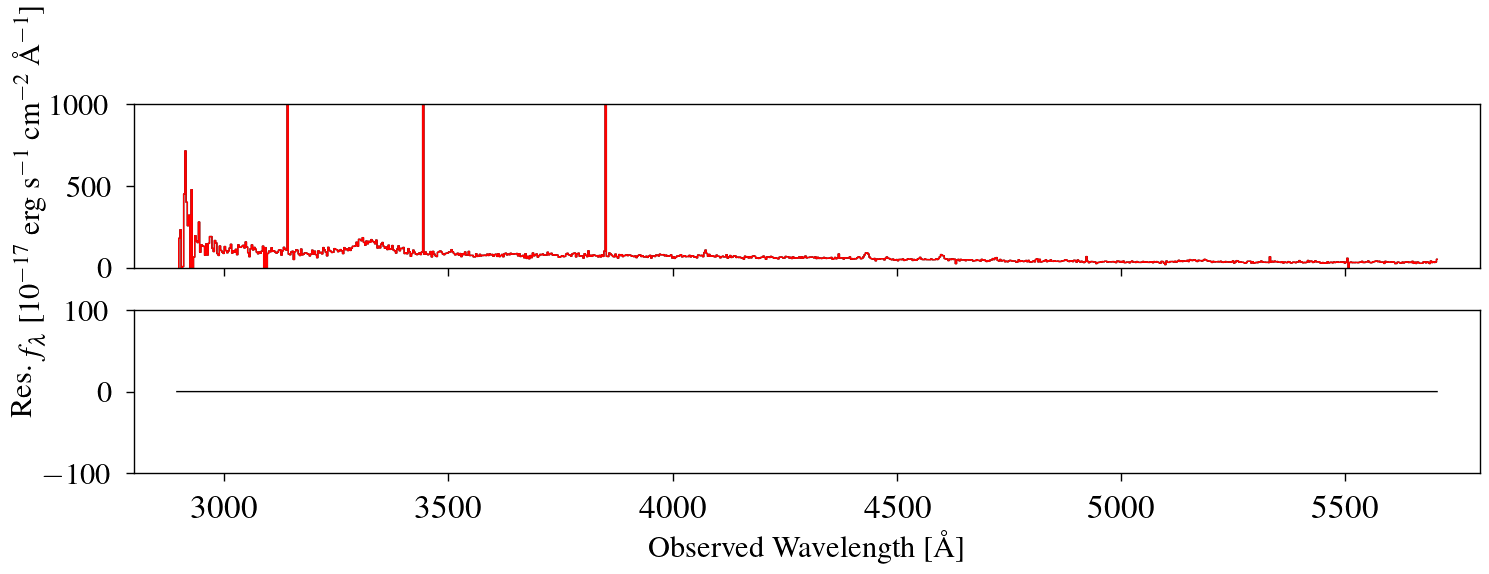

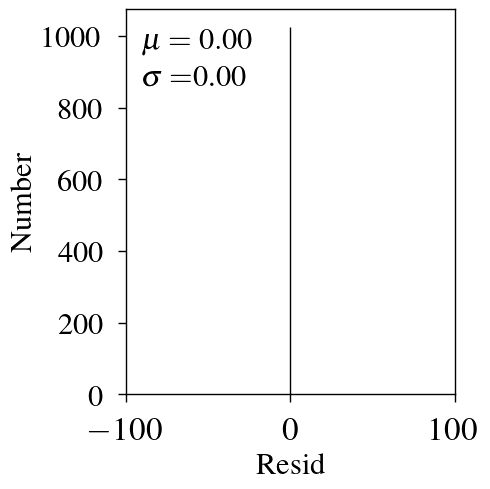

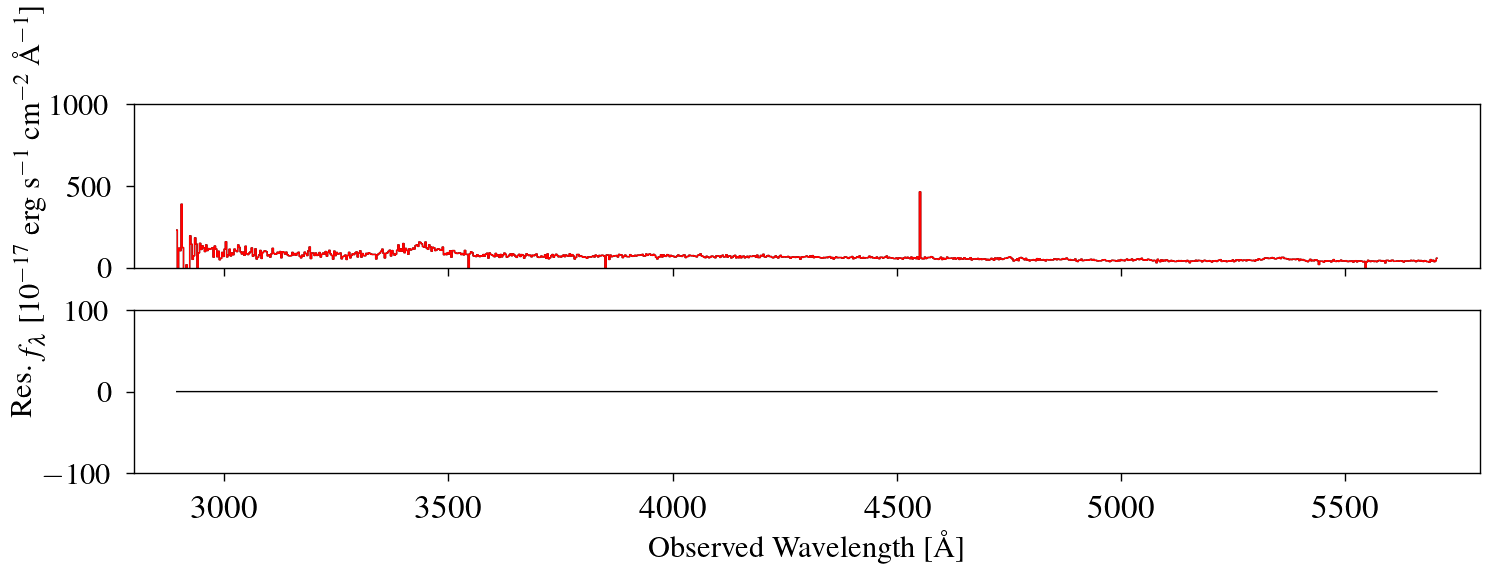

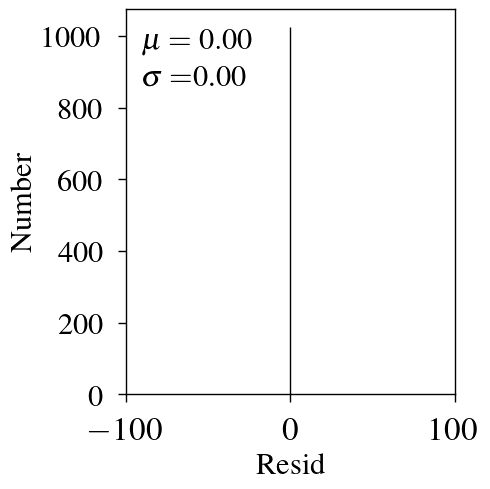

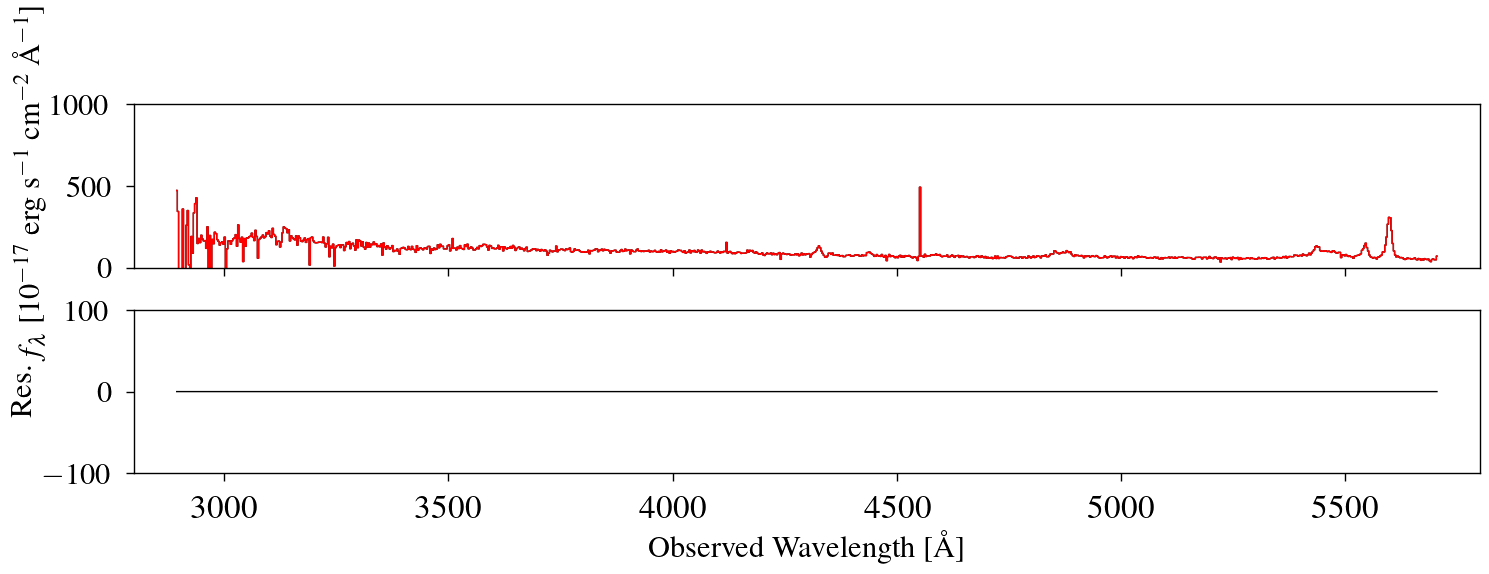

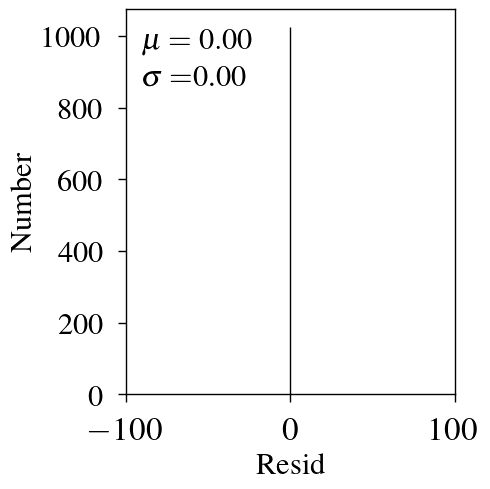

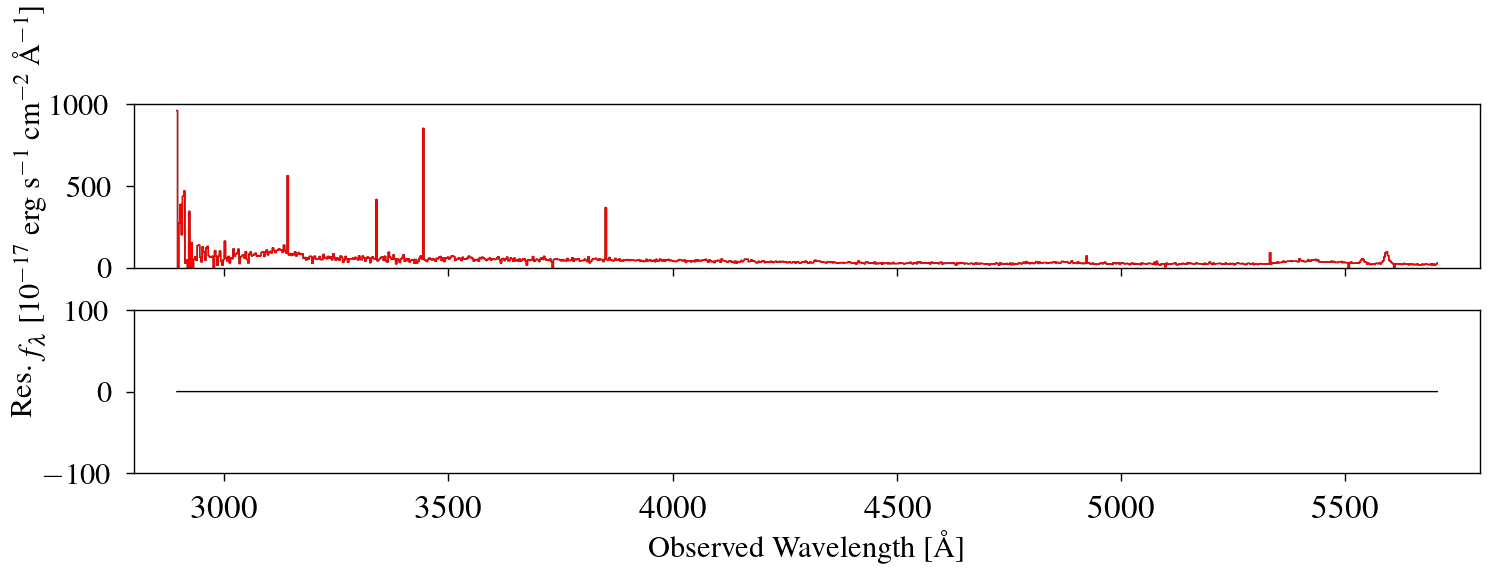

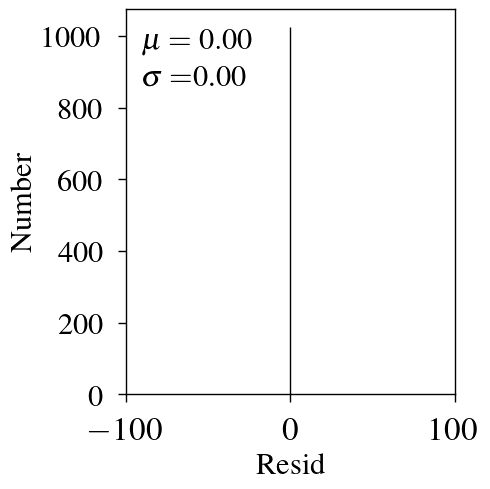

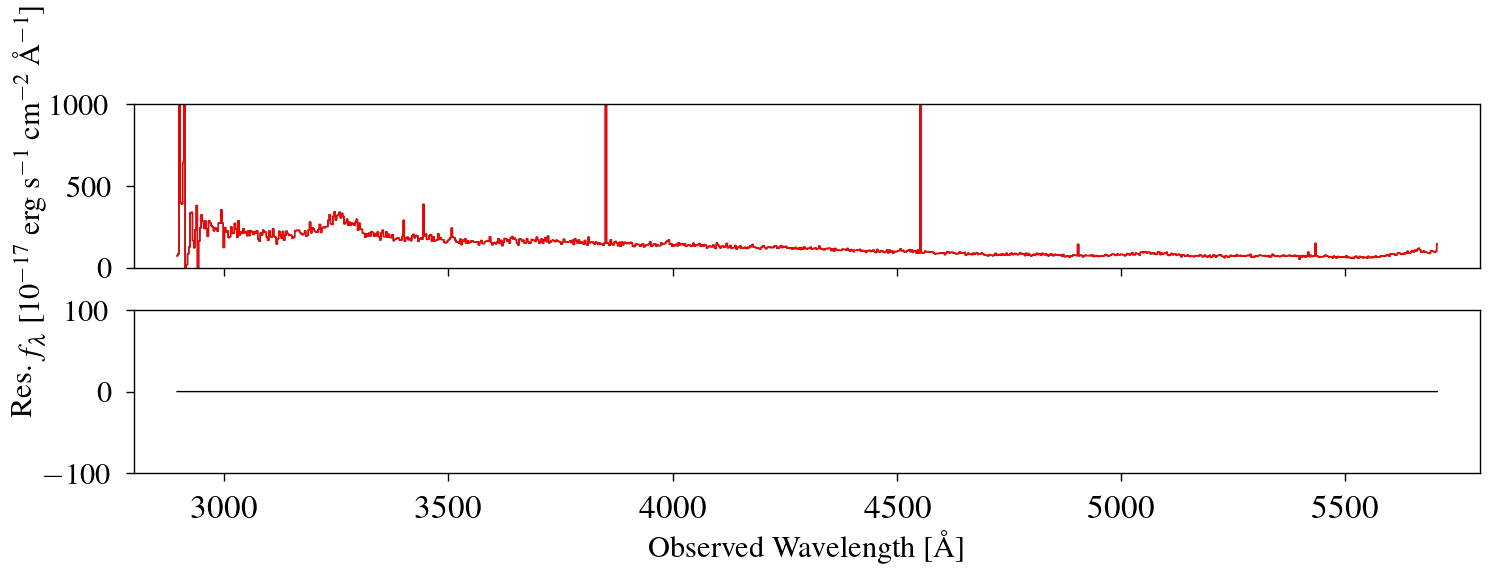

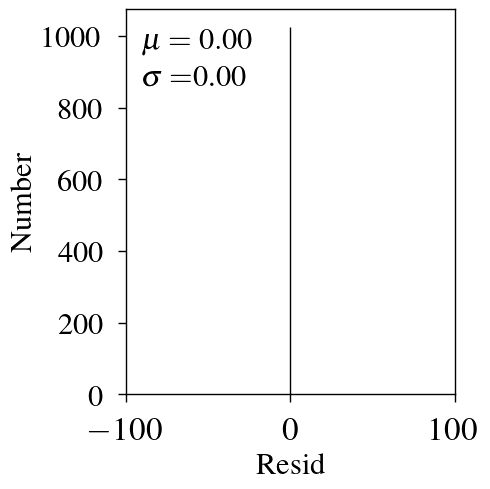

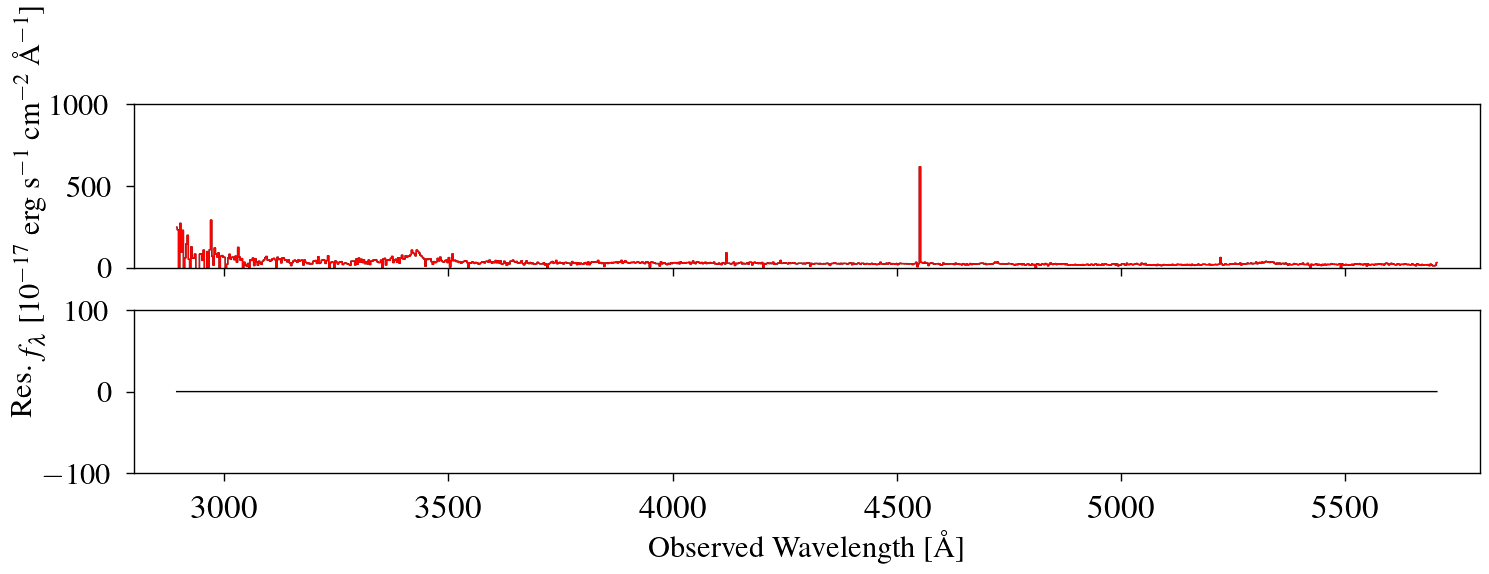

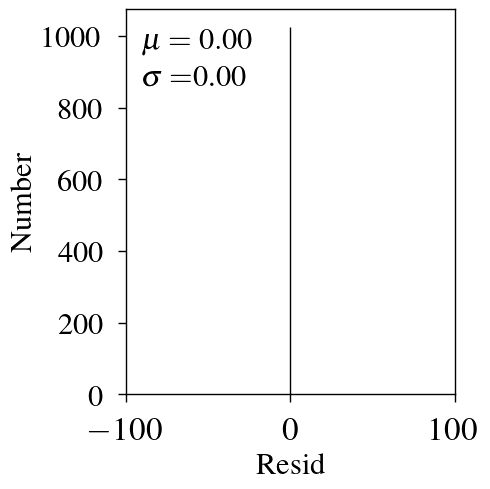

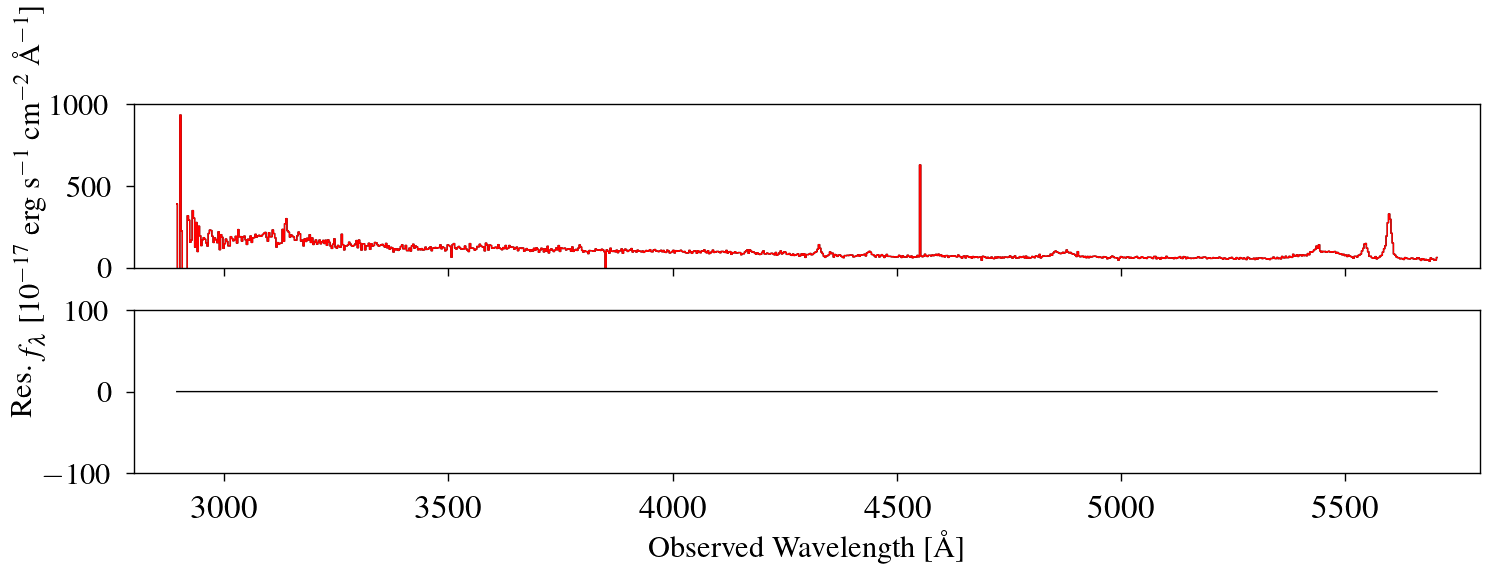

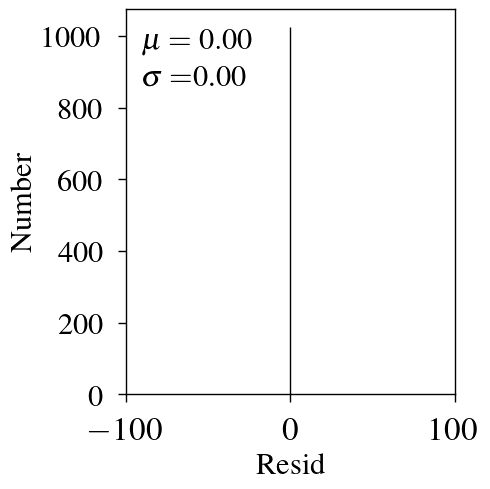

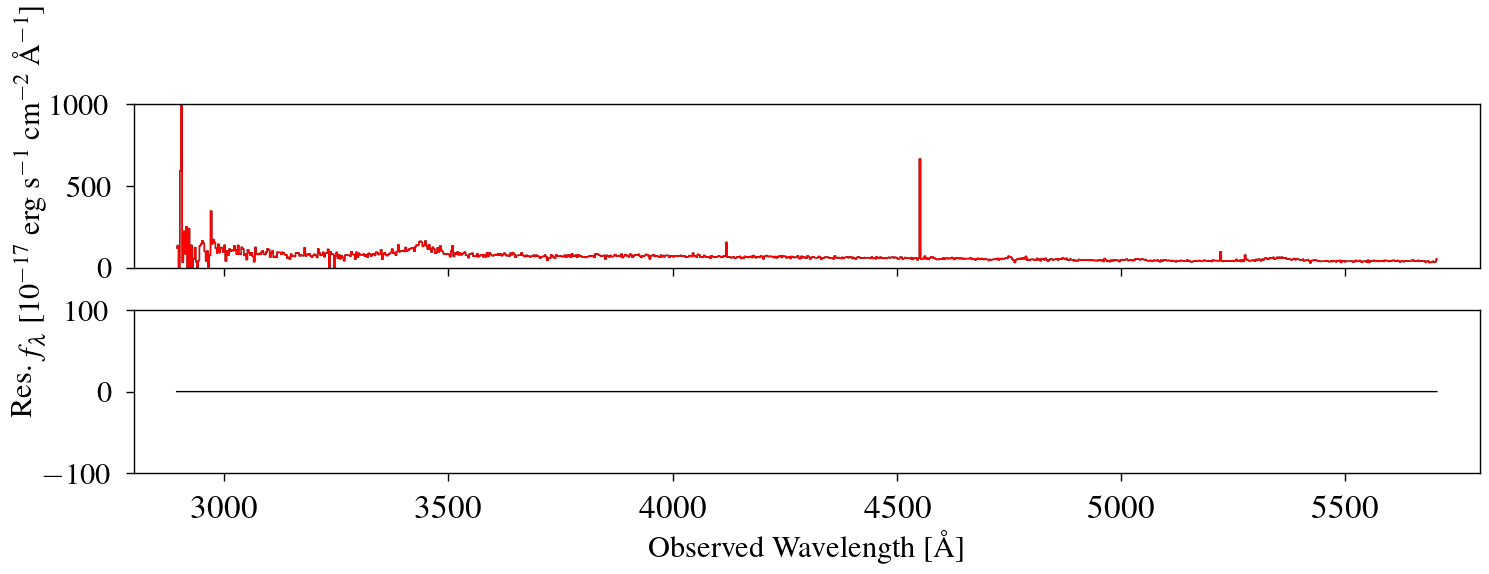

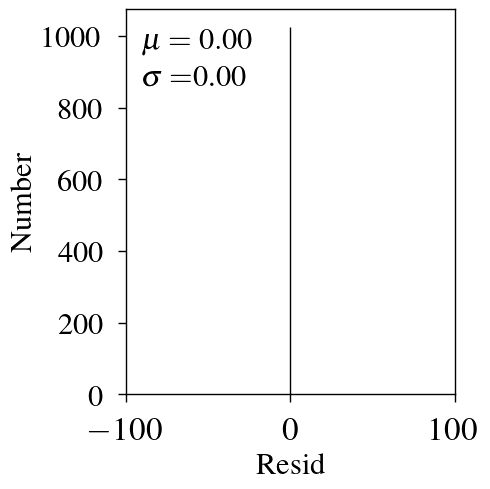

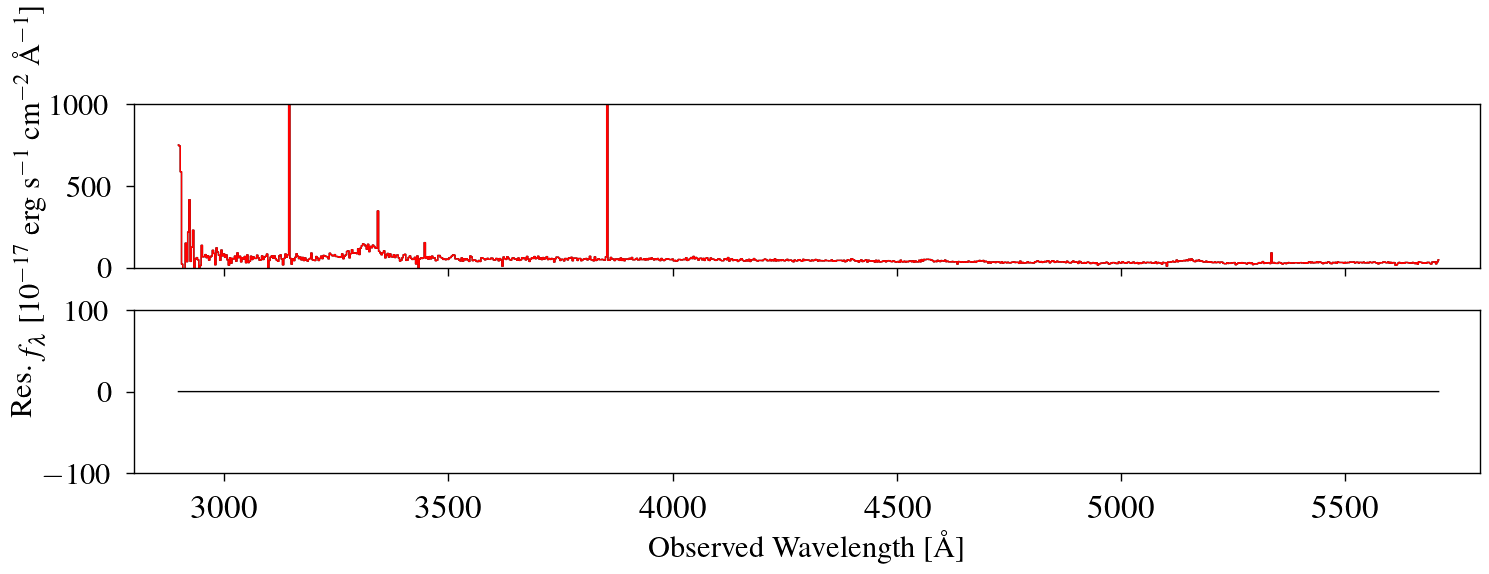

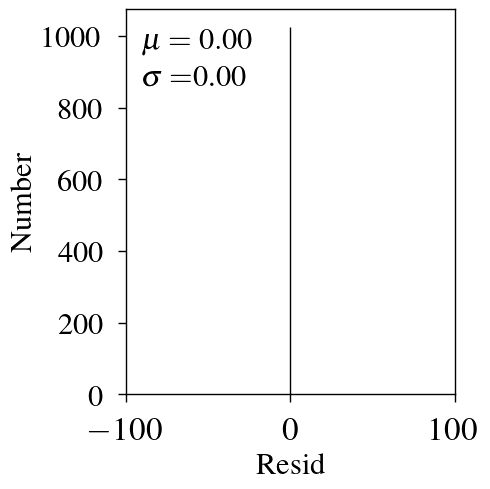

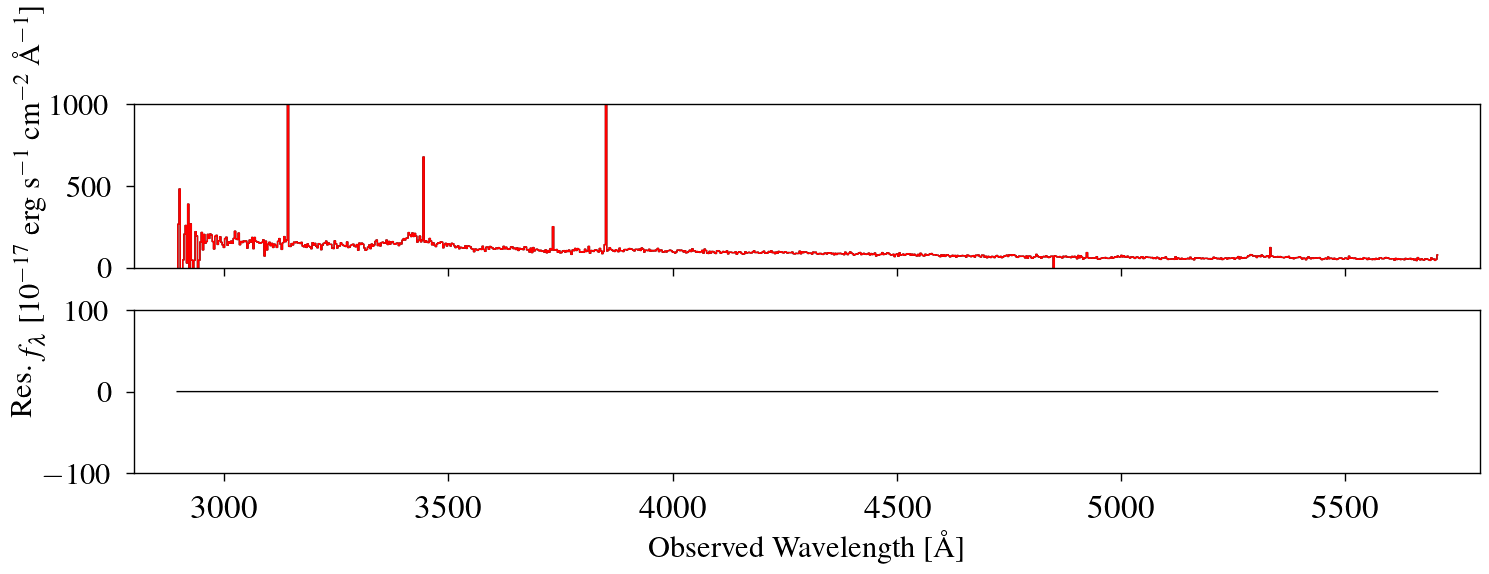

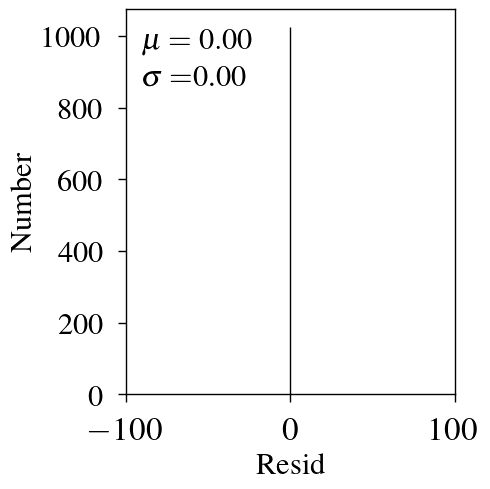

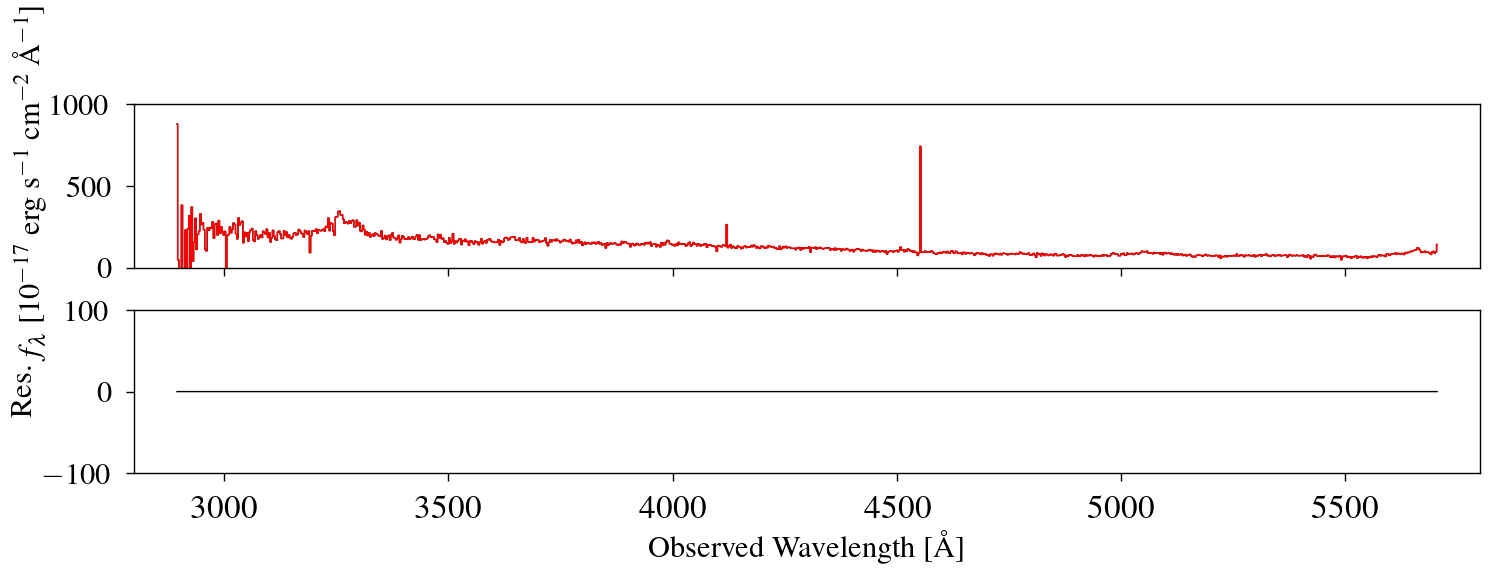

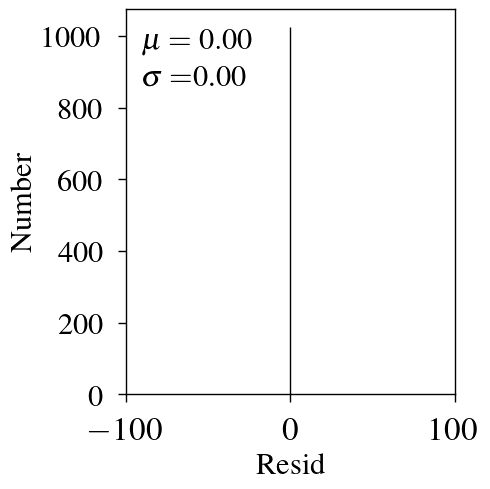

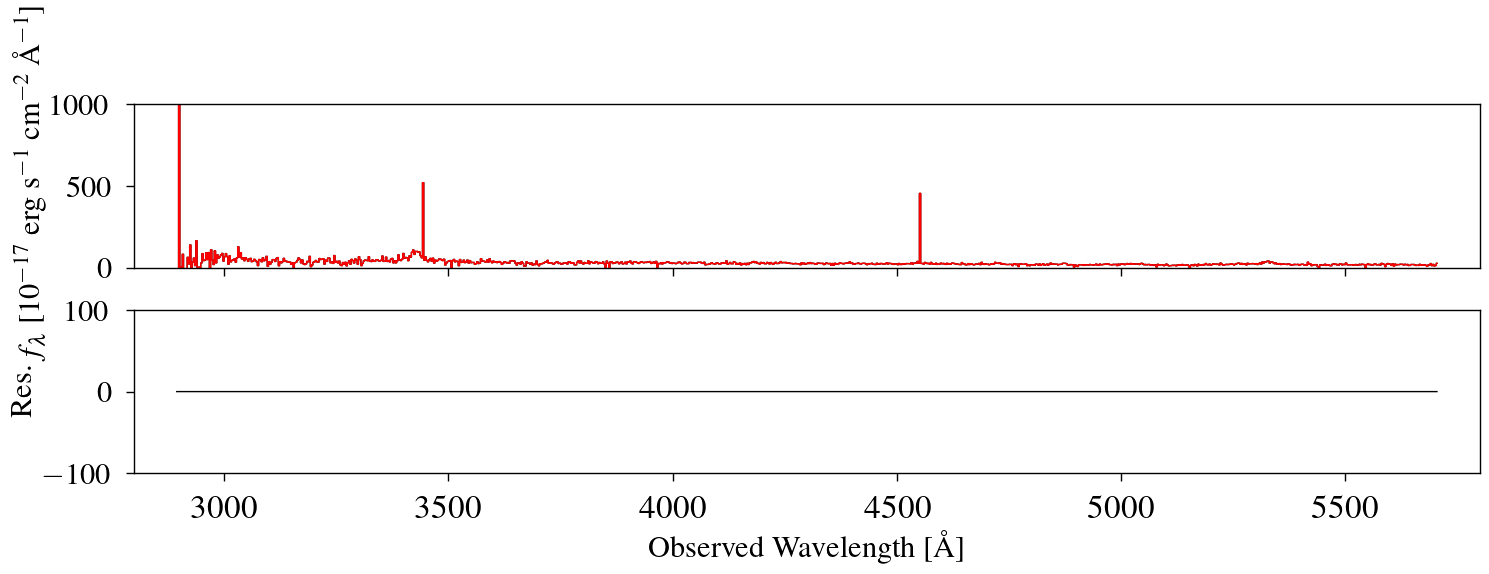

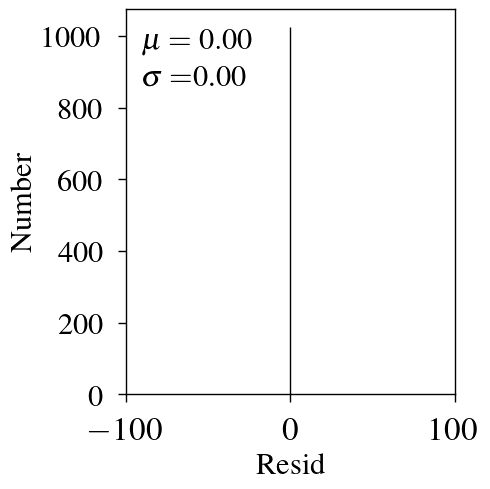

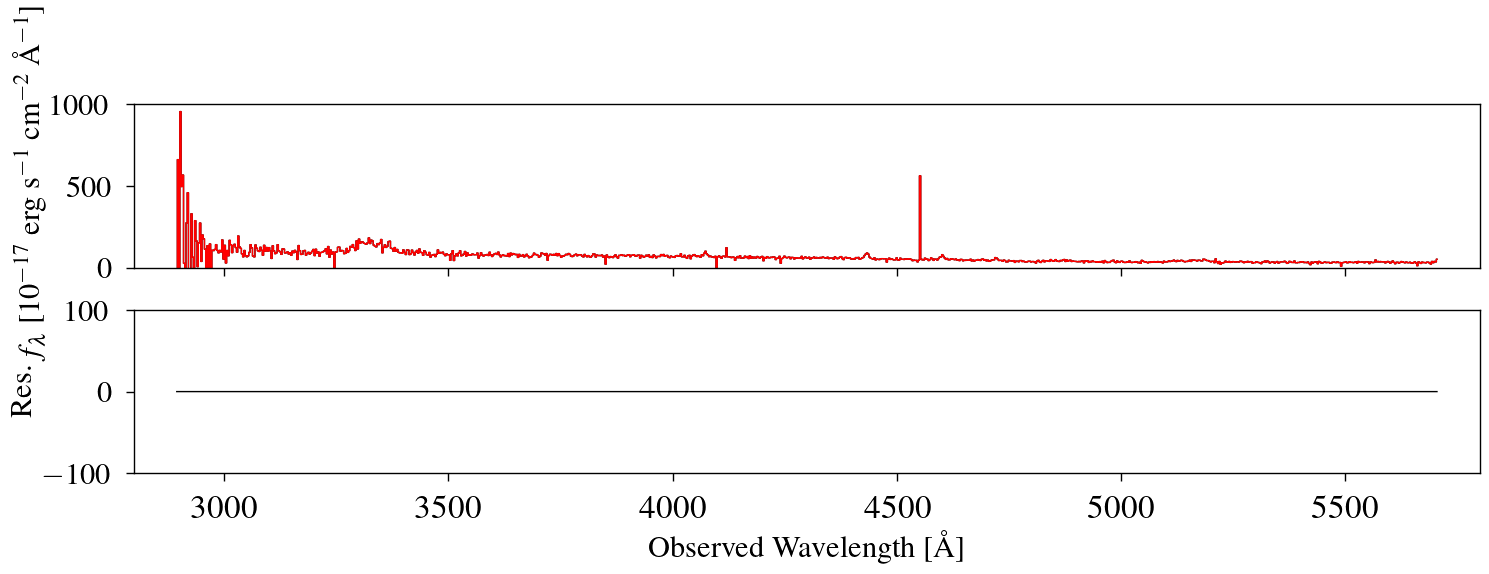

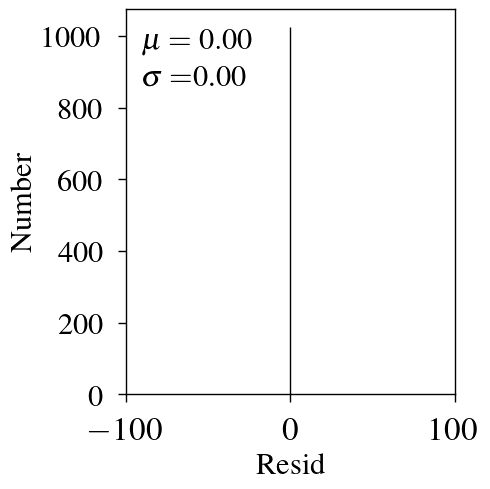

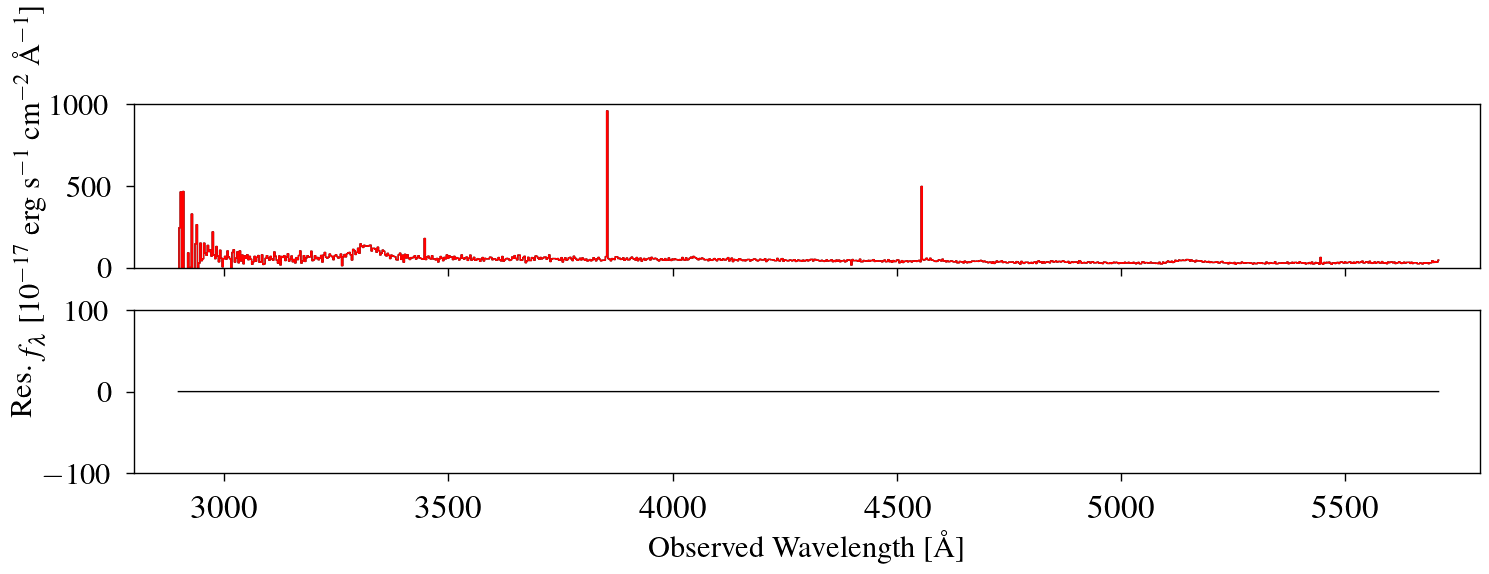

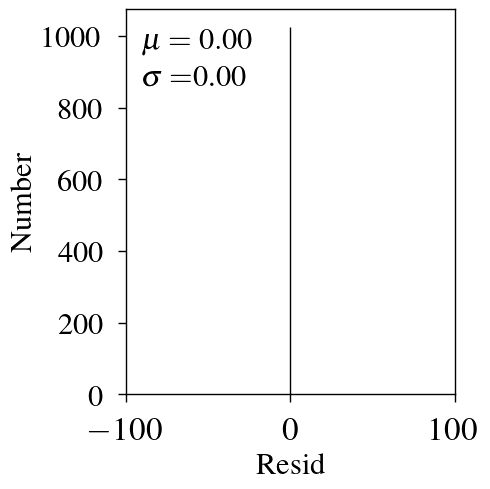

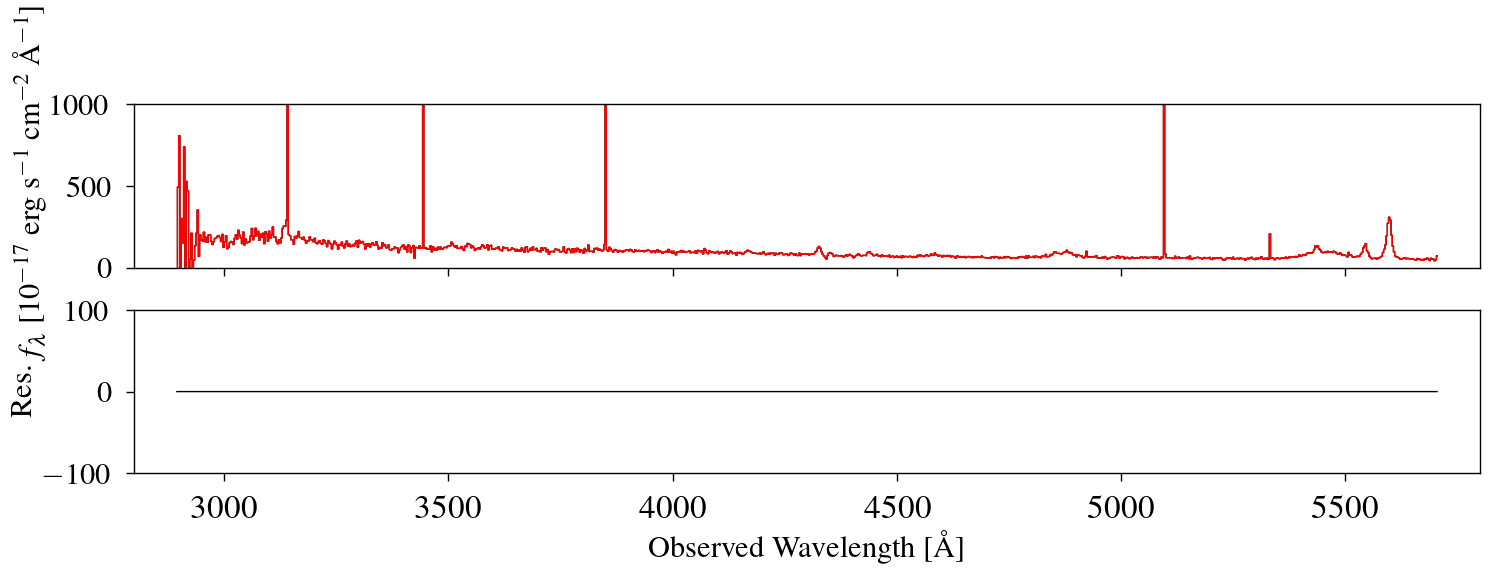

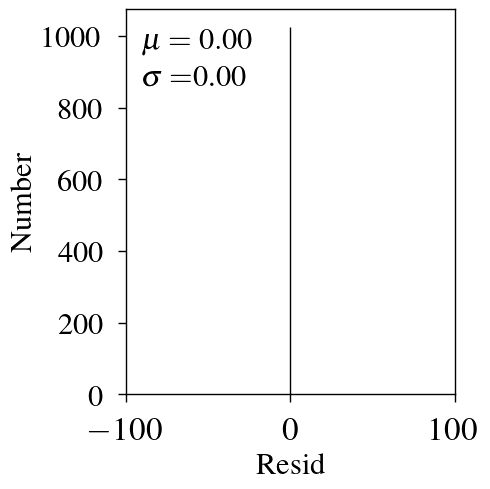

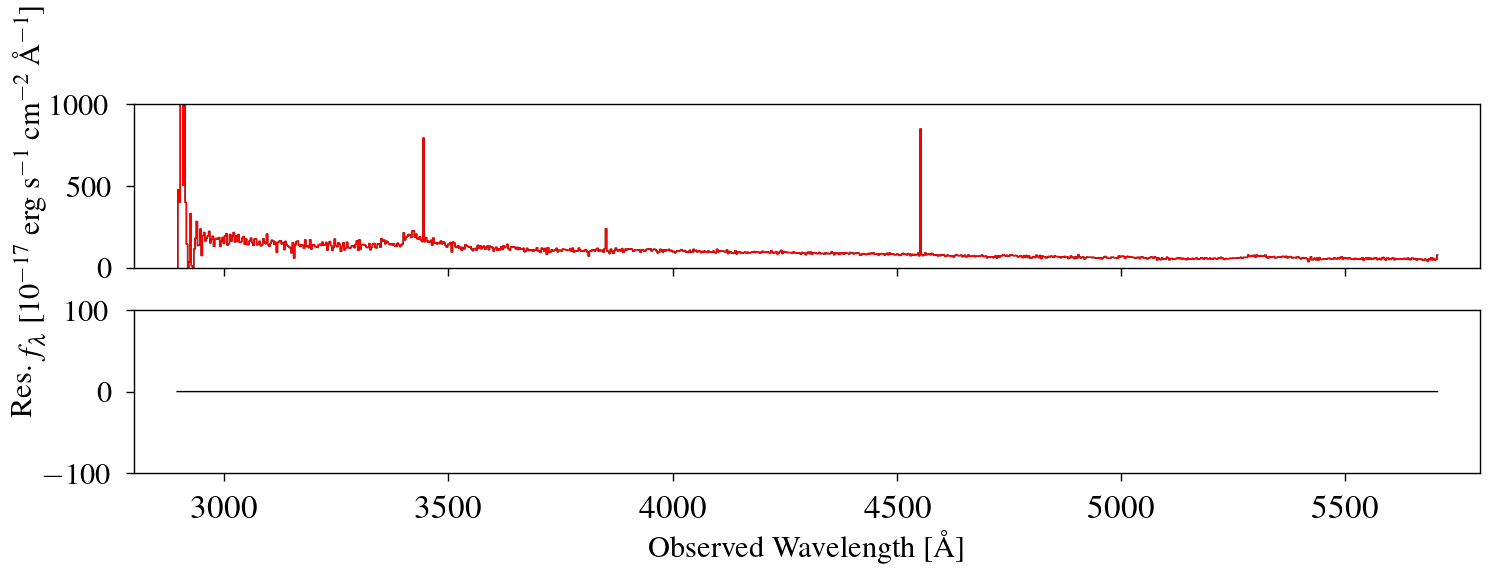

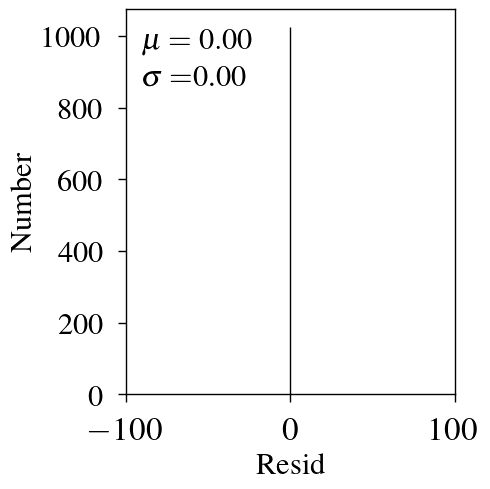

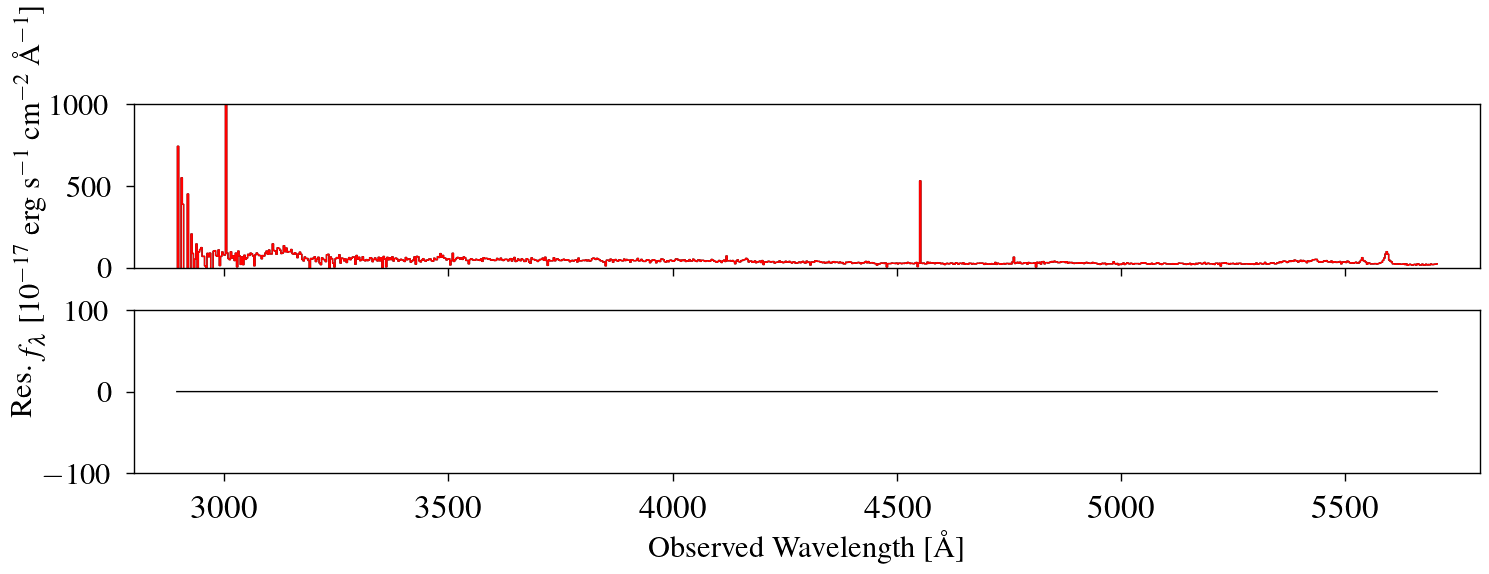

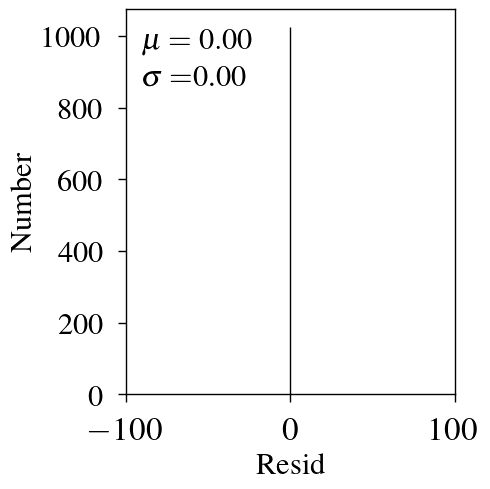

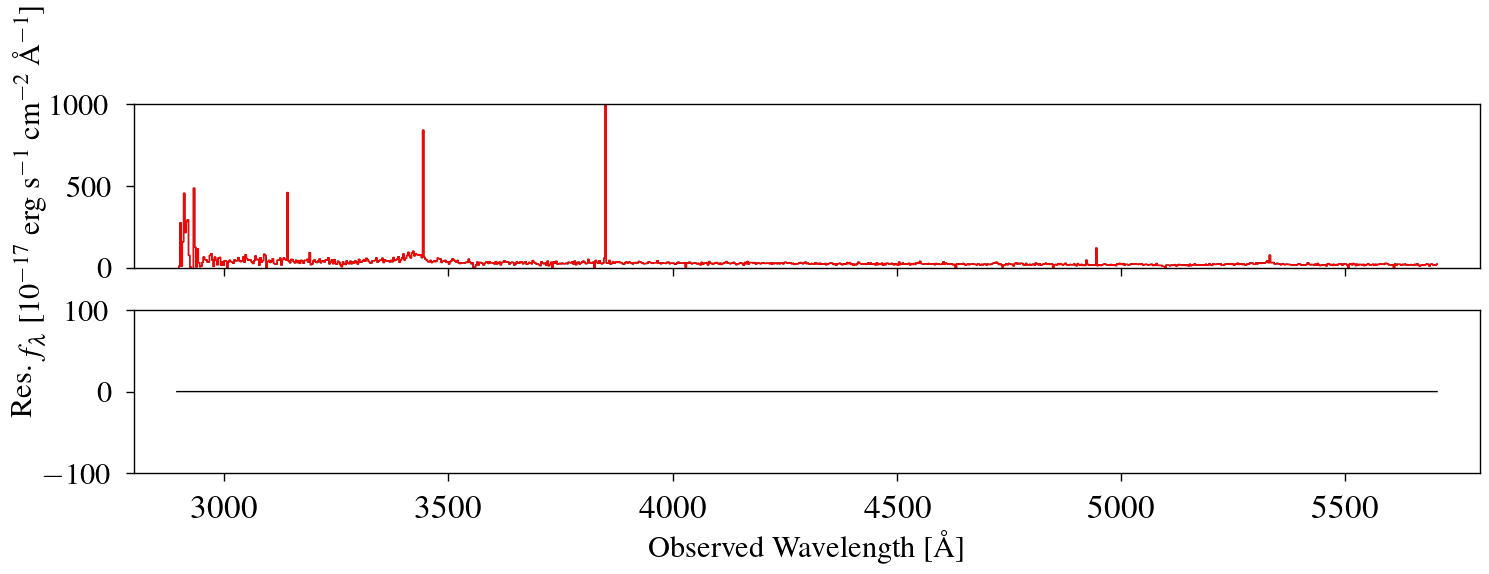

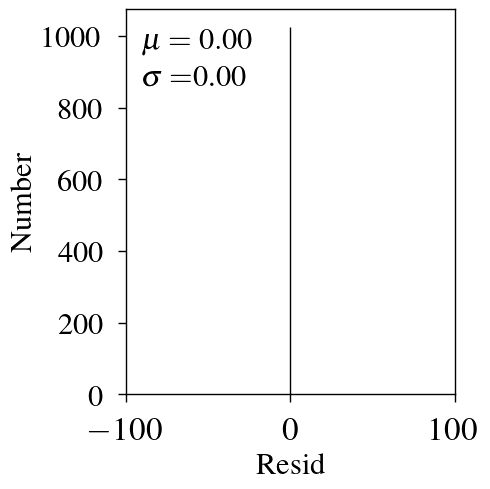

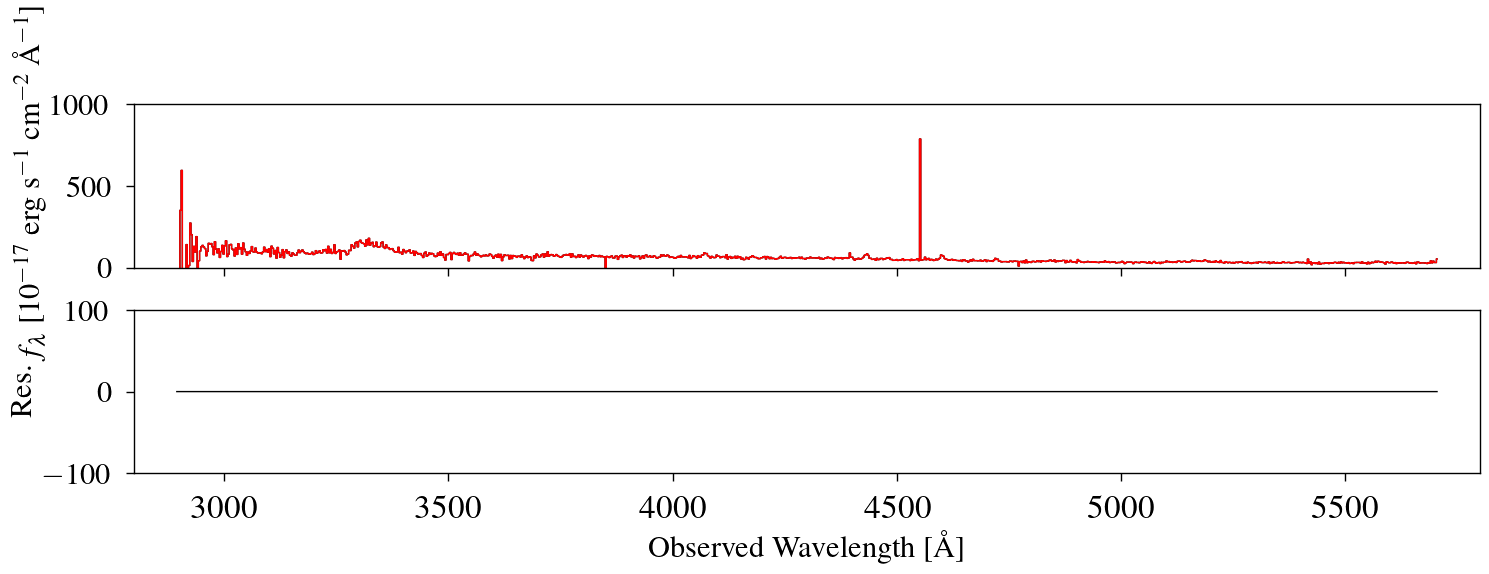

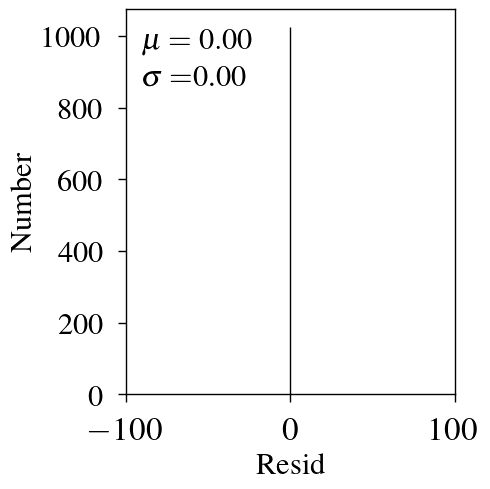

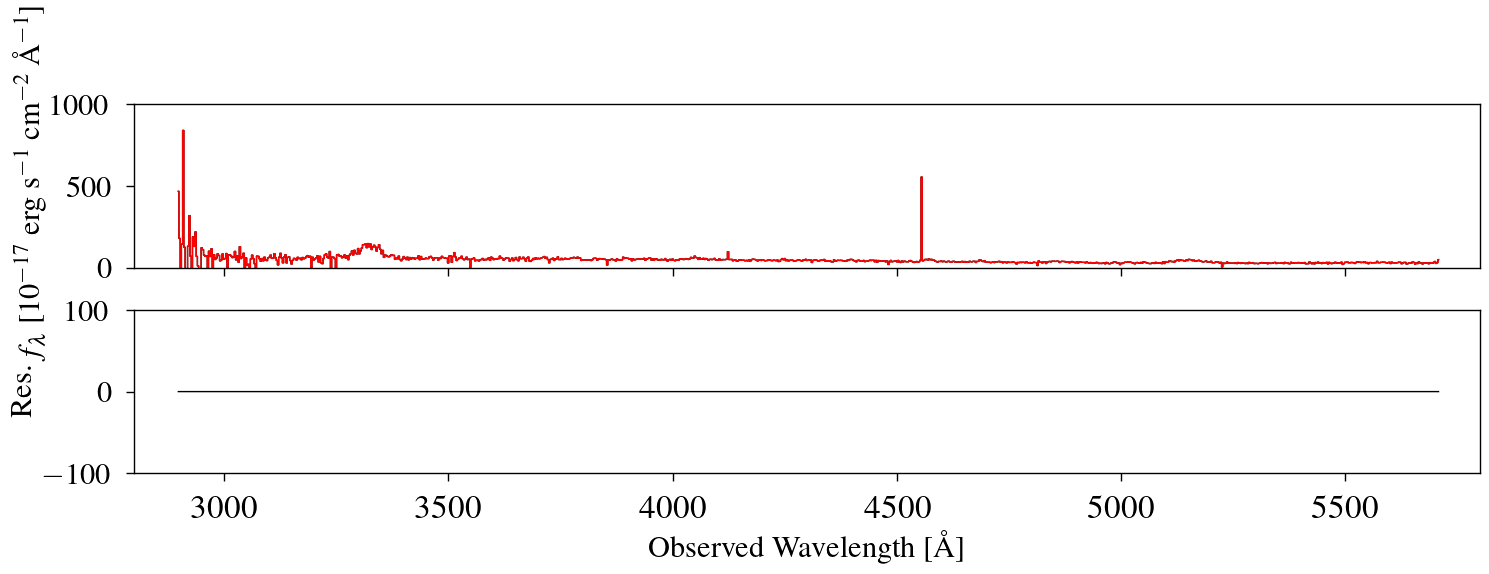

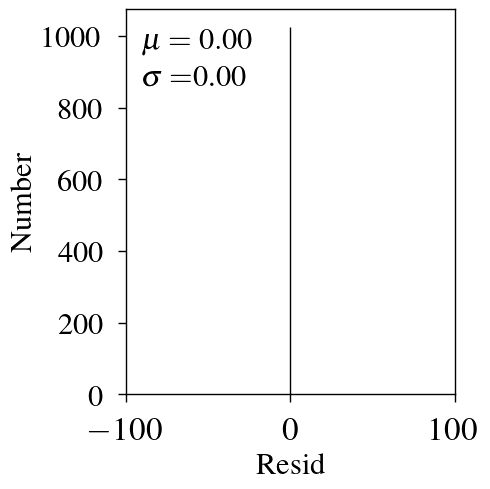

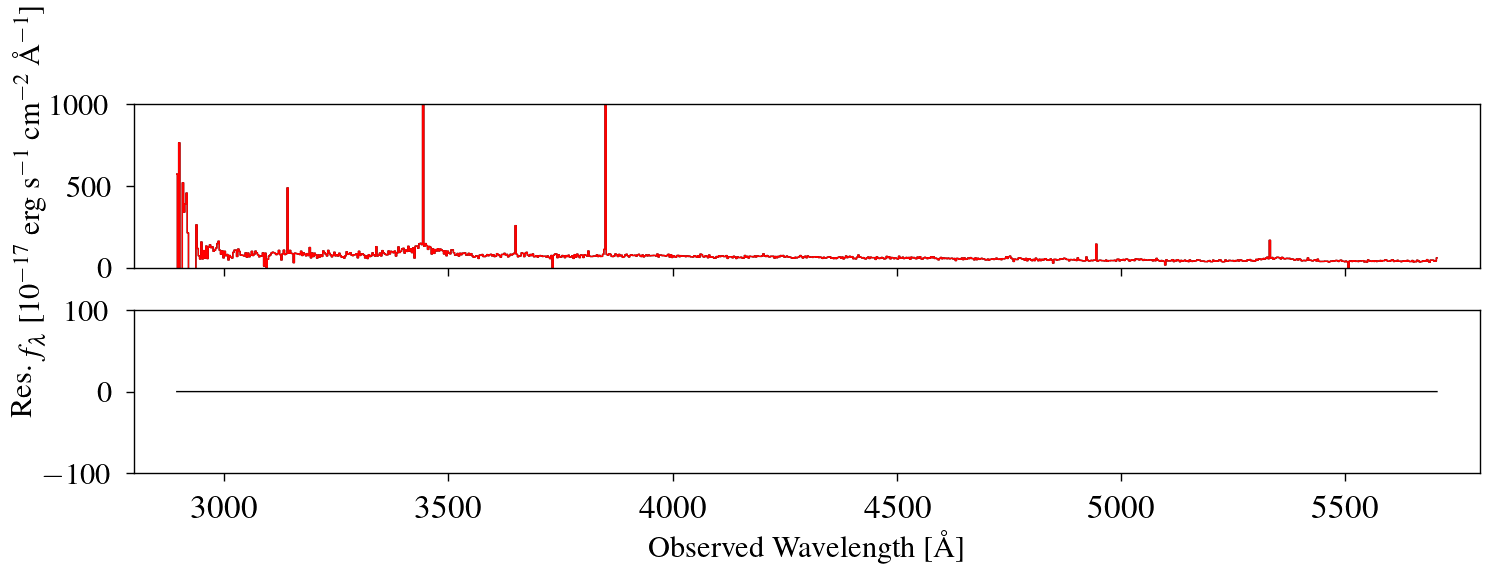

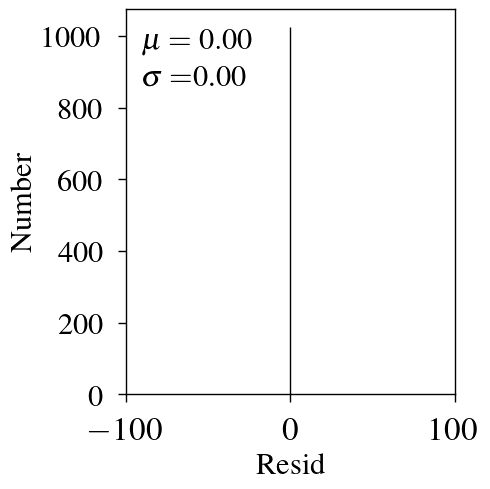

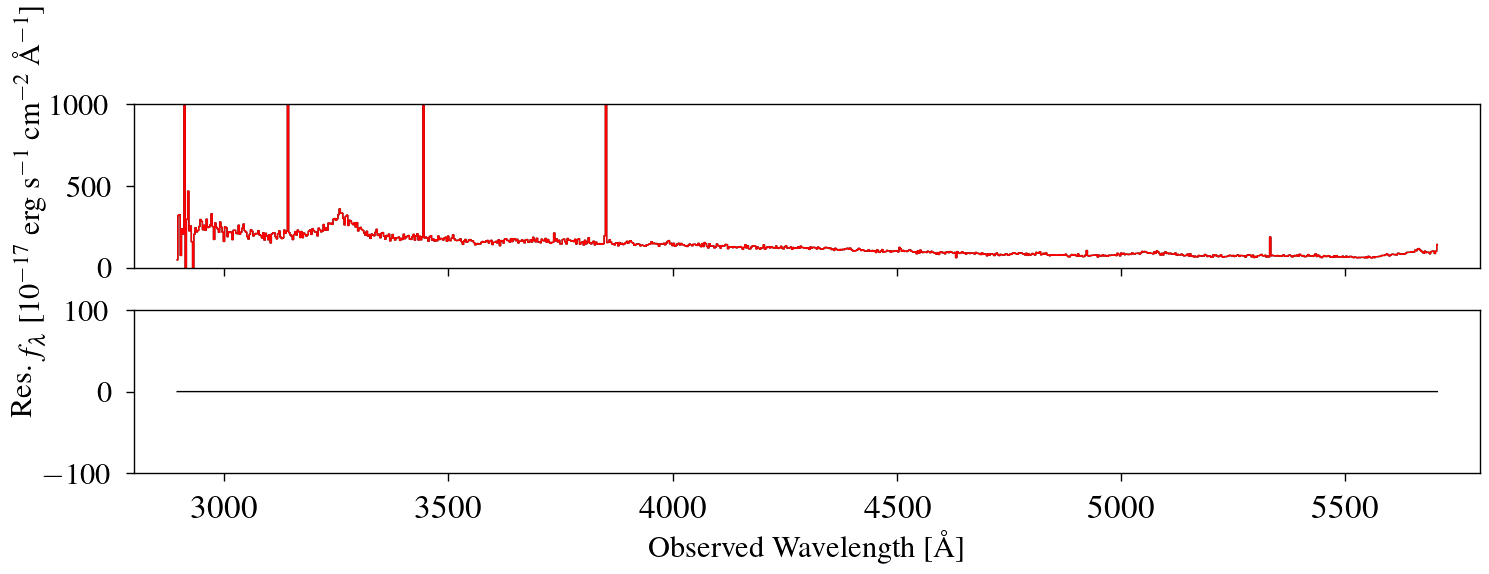

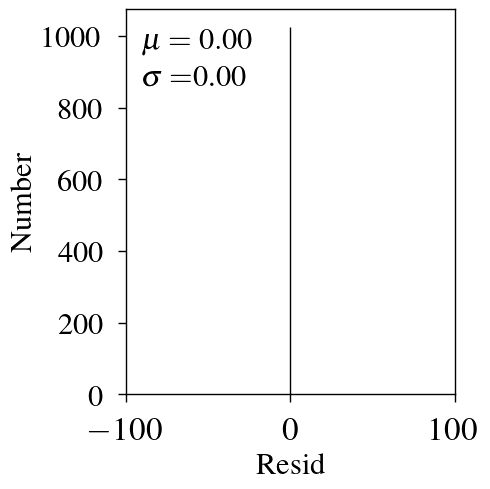

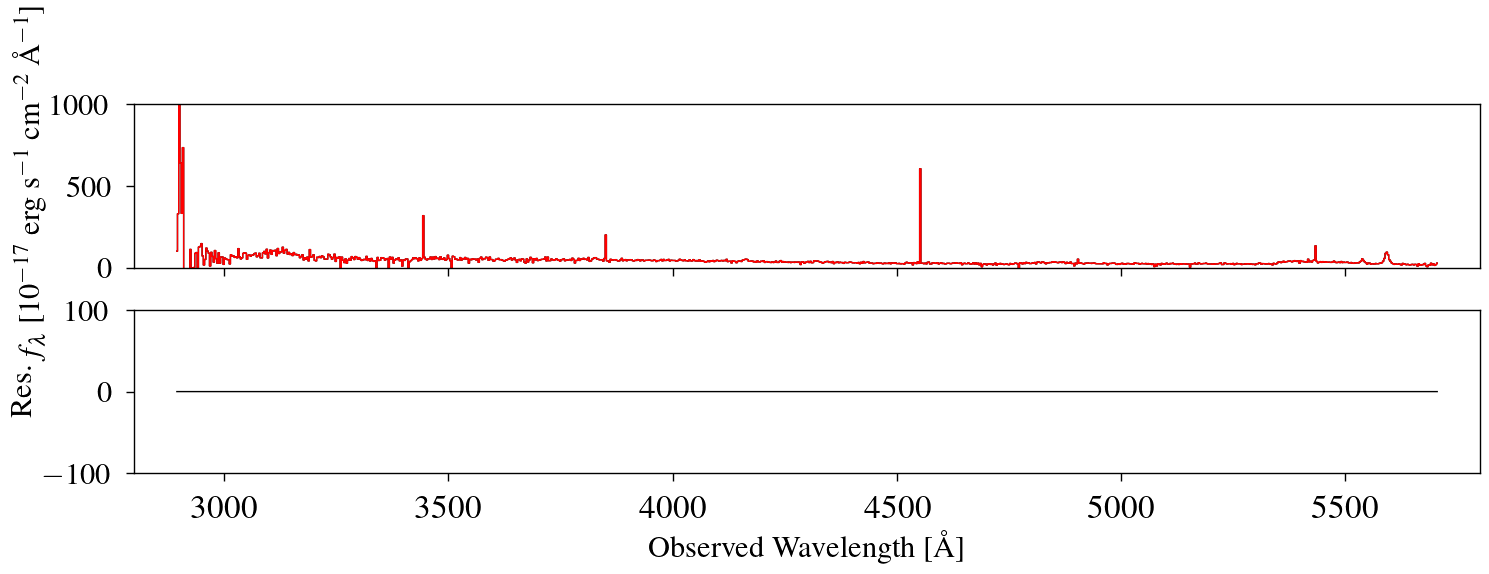

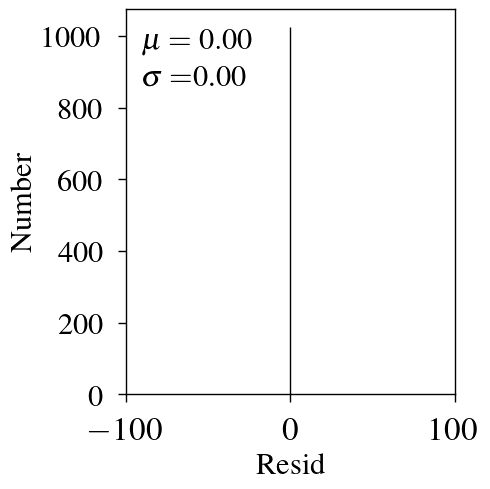

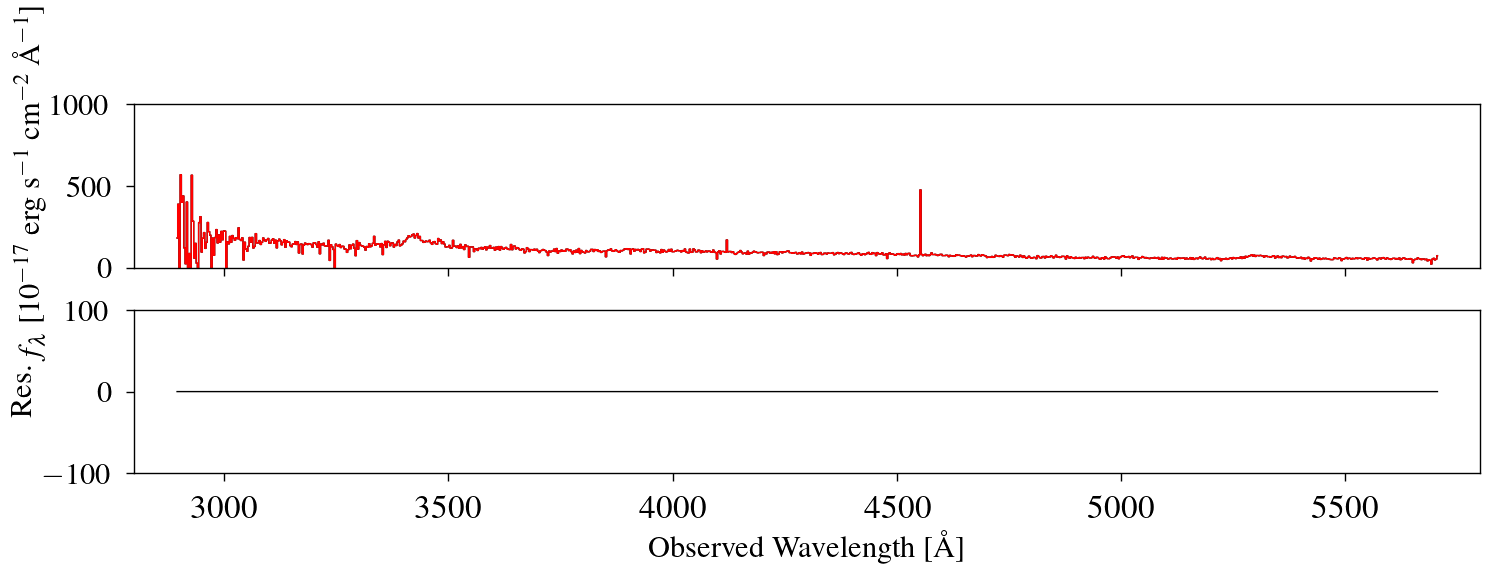

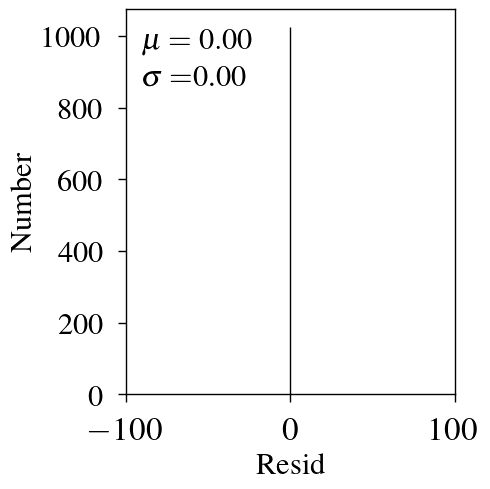

In [11]:
# loop over the files and plot both versions
for sx1_file in sx1_files:

    orig_hdu = fits.open(orig_dir+sx1_file)
    orig_dat = orig_hdu[1].data
    wave_orig = orig_dat['wavelength'][0]
    flux_orig = (1e17)*orig_dat['flux'][0]
    err_orig  = (1e17)*orig_dat['error'][0]
    
    new_hdu = fits.open(sx1_file)
    new_dat = new_hdu[1].data
    wave_new = new_dat['wavelength'][0]
    flux_new = (1e17)*new_dat['flux'][0]
    err_new  = (1e17)*new_dat['error'][0]
    
    ytit = '$f_{\lambda}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
    xtit = 'Observed Wavelength [\AA]'
    fig,(ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(15,5))
    ax1.plot(wave_orig,flux_orig,drawstyle='steps-mid',color='k')
    ax1.plot(wave_new,flux_new,drawstyle='steps-mid',color='r')
    ax1.set_ylim([0,1000])
    ax1.set_xlim([2800,5800])
    ax1.set_ylabel(ytit,size=22)
    ax2.plot(wave_orig,flux_orig-flux_new,drawstyle='steps-mid',color='k')
    ax2.set_ylim([-100,100])
    ax2.set_xlim([2800,5800])
    ax2.set_ylabel('Res.',size=22)
    ax2.set_xlabel(xtit,size=22)
    plt.tight_layout()
    plt.show() 
        
    fig,ax = plt.subplots(1, 1, figsize=(5,5))
    ax.hist(flux_orig-flux_new, bins=500,color='k',ec="k",fc='white')
    ax.set_xlim([-100,100])
    ax.set_xlabel('Resid',size=22)
    ax.set_ylabel('Number',size=22)
    ax.annotate('$\mu={0:0.2f}$'.format(np.mean(flux_orig-flux_new)), 
             xy=(0.05,0.9), 
             xycoords='axes fraction',
             color='black',
             size=22)
    ax.annotate('$\sigma=${0:0.2f}'.format(np.std(flux_orig-flux_new)), 
             xy=(0.05,0.8), 
             xycoords='axes fraction',
             color='black',
             size=22)
    plt.tight_layout()
    plt.show() 
        

# <span style='color:red'> Junk Code </span>

In [ ]:
#hdu = fits.open(man_dir+'obji20010_raw.fits')
#hdr = hdu[0].header
#hdr
#
##CRDS_CTX
#for file in raw_files:
#    ctx = fits.getval(man_dir+file,'CRDS_CTX')
#    print(ctx)

## Contemporaneous wavecal 

In [ ]:
## copy the pipeline _wav files to the reduced directory
#os.system('cp '+raw_dir+'*_wav.fits '+man_dir)
#
## grab the raw files
#wav_files = np.sort(glob.glob('*_wav.fits'))
#wav_files

In [ ]:
## do the bias correction
## loop over the raw files
## this will handle multiple CRSPLIT extensions per file
#for wav_file in wav_files[0:2]:
#    print('Reducing '+wav_file+'.')
#    # get the root filename
#    file = wav_file.replace('_wav.fits','',1)
#    
#    # preference is given to tasks requested in header keywords over in basic2d below
#    # set these so that we only do the bias correction tasks
#    # turn off all the corrections except for the three for bias
#    #set_basic2d_keys(all_corrs,man_dir+raw_file)                              
#            
#    # run the bias level and frame subtraction
#    print('    Starting bias, dark, and flat corrections...')
#    stistools.basic2d.basic2d(input=man_dir+wav_file,output=man_dir+file+'_fwv_tmp.fits',
#                              verbose=True,trailer=man_dir+file+'_trl.log',
#                              dqicorr='perform',
#                              blevcorr='perform',
#                              biascorr='perform',
#                              darkcorr='perform',
#                              flatcorr='perform',
#                              atodcorr='omit',
#                              doppcorr='omit', 
#                              lorscorr='omit',
#                              glincorr='omit',
#                              lflgcorr='omit',
#                              shadcorr='omit',
#                              photcorr='omit',
#                              statflag=True)
#    print('Done.')
#  
#stistools.x2d.x2d(input, output='', helcorr='perform', fluxcorr='perform', statflag=True, center=False, blazeshift=None, err_alg='wgt_var', verbose=False, timestamps=False, trailer='', print_version=False, print_revision=False)
#
#
#
#
#    stistools.wavecal.wavecal(man_dir+file+'_crj.fits',man_dir+file+'_fwv_tmp.fits', 
#                              debugfile='', 
#                              savetmp=False, 
#                              option='linear', 
#                              angle=None, 
#                              verbose=False, 
#                              timestamps=False, 
#                              trailer=man_dir+file+'_trl.log', 
#                              print_version=False, 
#                              print_revision=False)
#    
#    
#    

In [ ]:
def set_basic2d_keys(all_corrs,path):
#-------------------------------------------------------------
#+
# NAME:
#       SET_BASIC2D_KEYS
#
# PURPOSE:                                                 
#   Grab header information and set keywords for basic2d tasks.
#
# CALLING SEQUENCE:
#       set_basic2d_keys(all_corrs,path)
#
# INPUTS:
#   all_corrs - keywords with a boolean to turn them on/off 
#   path      - path to the header that needs to be changed
#
#
# NOTES:
#
#
# EXAMPLE:
# 
# all_corrs = {'DQICORR':True,
#             'BLEVCORR':True,
#             'BIASCORR':True,
#             'CRCORR':False,
#             'RPTCORR':False,
#             'EXPSCORR':False,
#             'DARKCORR':False,
#             'FLATCORR':False,
#             'STATFLAG':False,
#             'WAVECORR':False,
#             'X1DCORR':False,
#             'BACKCORR':False,
#             'HELCORR':False,
#             'DISPCORR':False,
#             'FLUXCORR':False,
#             'CTECORR':False,
#             'X2DCORR':False}
#
# set_basic2d_keys(all_corrs,'/Users/runnojc1/stis_reduce/obji14010_raw.fits') 
#
# MODIFICATION HISTORY:
#    JCR, 22 Nov 2022: VERSION 1.00
#       - Wrote first version of this code.
#-
#-------------------------------------------------------------     
    for key in all_corrs.keys():
        if all_corrs[key]:
            if key != 'STATFLAG':
                print('Setting '+key+': PERFORM')
                fits.setval(path,key,value='PERFORM')
            else:
                print('Setting '+key+': T')
                fits.setval(path,key,value=True)                
        else:
            if key != 'STATFLAG':
                print('Setting '+key+': OMIT')
                fits.setval(path,key,value='OMIT') 
            else:
                print('Setting '+key+': F')
                fits.setval(path,key,value=False)